Dans ce notebook, nous allons segmenter les clients en utilisant les modèles de classification non supervisée. Pour ce faire nous devons tout d'abord préparer nos données:  
  1- Encodage des variables qualitatives  
  2- Standardisation des variables  
  3- ACP
  
Une fois que les données sont prétraitées, nous allons employer 3 algorithmes de classification non supervisée:  
    - KMeans  
    - DBscan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import my_module as my
import seaborn as sns
from datetime import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
# Option d'affichage
pd.set_option("display.max_rows", 2000)
pd.set_option("display.max_columns", 2000)

In [3]:
#lecture des données 
df = pd.read_csv('df.csv')
rfm_results = pd.read_csv('rfm_results.csv')

In [4]:
df.head()

,Unnamed: 0,customer_id,customer_unique_id,order_id,order_date,review_score,payment_sequential,payment_type,payment_installments,payment_value,freight_value,category_name,evaluateur,reactivite,distance_clientVendeur,order_hour,order_day,order_weekday,order_month,order_year,purchase_weekend
0,0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,4.0,1.0,credit_card,2.0,146.87,21.88,office_furniture,0,4.0,348.67,15,16,1,5,2017,0
1,1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,5.0,1.0,credit_card,8.0,335.48,46.48,housewares,0,11.0,413.82,20,12,4,1,2018,0
2,2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,5.0,1.0,credit_card,7.0,157.73,17.79,office_furniture,0,0.0,29.95,16,19,5,5,2018,1
3,3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,5.0,1.0,credit_card,1.0,173.30,23.36,office_furniture,0,4.0,18.50,16,13,1,3,2018,0
4,4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,5.0,1.0,credit_card,8.0,252.25,22.25,home_confort,1,7.0,220.06,9,29,6,7,2018,1


In [5]:
rfm_results.head()

,customer_id,recence,frequence,montant,R,F,M,categorie
0,00012a2ce6f8dcda20d059ce98491703,411,0.693147,4.751346,2,1,3,Others
1,000161a058600d5901f007fab4c27140,532,0.693147,4.225519,1,1,2,Client perdu
2,0001fd6190edaaf884bcaf3d49edf079,670,0.693147,5.280255,1,1,3,Others
3,0002414f95344307404f0ace7a26f1d5,501,0.693147,5.194899,1,1,3,Others
4,000379cdec625522490c315e70c7a9fb,272,0.693147,4.682224,3,1,2,Client potentiel


**Rappeler la segmentation avec RFM**

In [6]:
#visualisation 3D
def projection_3d_segments(rfm_results, label_categorie) :
    """
    Graphique montrant les différents clients associés à leur segment/cluster respectif
    rfm_results(pd.DataFrame): Table de résultats
    label_categorie(str): nom du segment
    colors(list): liste de couleurs

    """
    fig = plt.figure(1, figsize=(20, 10))

    dx = fig.add_subplot(111, projection='3d')
    # Pour chaque segment, scatter plot des individus avec code couleur
    for i, segment in enumerate(rfm_results[label_categorie].unique()):
        dx.scatter(rfm_results[rfm_results[label_categorie] == segment].recence,
                   rfm_results[rfm_results[label_categorie] == segment].frequence,
                   rfm_results[rfm_results[label_categorie] == segment].montant,
                   label=segment,
                   s=50)
    # Titre des axes et titre graphique
    dx.set_xlabel("Recence")
    dx.set_ylabel("Frequence")
    dx.set_zlabel("Montant")
    plt.title("Représentation 3D des différents individus dans chaque segment")

    plt.legend()
    plt.show()

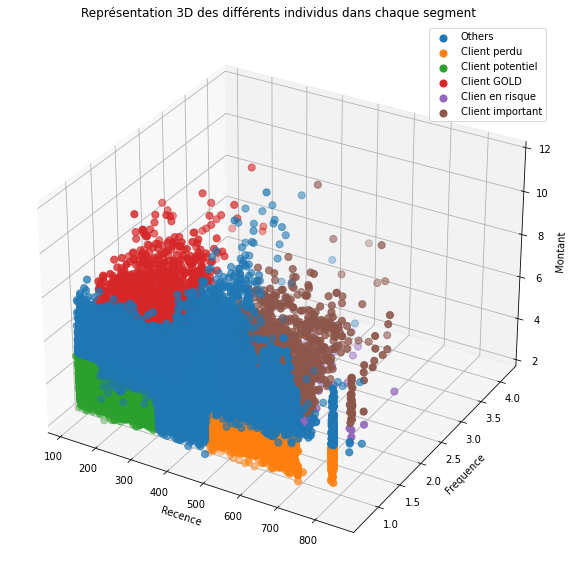

In [7]:
# Graphique 3D (x, y, z) = (Recence, Frequence, Montant)
projection_3d_segments(rfm_results, 'categorie')

## 1. Segmentation non supervisée des clients : KMeans
### 1.1. Prétraitement des données

Dans cette partie, les variables qu'on va utiliser pour le machine learning sont: 
['customer_id', 'review_score','payment_sequential', 'payment_type', 'payment_installments', 'payment_value', 'freight_value', 'category_name', 'distance_clientVendeur', 'evaluateur', 'reactivite']. 
Nous allons aussi rajouter les variables RFM comme nouvelle features à analyser

In [8]:
df['payment_type'].unique()

array(['credit_card', 'debit_card', 'voucher', 'boleto'], dtype=object)

In [9]:
df.columns

Index(['Unnamed: 0', 'customer_id', 'customer_unique_id', 'order_id',
       'order_date', 'review_score', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'freight_value',
       'category_name', 'evaluateur', 'reactivite', 'distance_clientVendeur',
       'order_hour', 'order_day', 'order_weekday', 'order_month', 'order_year',
       'purchase_weekend'],
      dtype='object')

In [10]:
#recupérer les données interessantes pour l'analyse des clients

finaldf = df[['customer_id', 'customer_unique_id', 'order_date',

       'review_score', 'payment_sequential', 'payment_type',

       'payment_installments', 'payment_value', 'freight_value',

       'category_name', 'evaluateur', 'reactivite', 'distance_clientVendeur']]

finaldf.shape

(118393, 13)

In [11]:
#merger finaldf avec rfm_results pour recuperer RFM

finaldf = finaldf.merge(rfm_results, how="left", on ='customer_id')

finaldf = finaldf.drop(columns=['R', 'F', 'M', 'categorie'])

finaldf.columns

Index(['customer_id', 'customer_unique_id', 'order_date', 'review_score',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'freight_value', 'category_name', 'evaluateur',
       'reactivite', 'distance_clientVendeur', 'recence', 'frequence',
       'montant'],
      dtype='object')

In [12]:
finaldf.shape

(118393, 16)

### a. Encodage des variables qualitatives

Pour encoder les variables qualitatives, nous allons tout d'abord créer des superclasses pour category_name. Ensuite, nous allons utiliser l'encodeur OnehotEncoder

In [13]:
print('le nombre de catégories initial est : ',finaldf['category_name'].nunique())

le nombre de catégories initial est :  71


In [14]:
#creer un dictionnaire pour regrouper les différentes catégories des produits sous des sub-classes

finaldf['categorie_produit'] = np.where((finaldf['category_name'].str.contains("fashio|luggage")==True),

                                    'mode',

                           np.where((finaldf['category_name'].str.contains("health|beauty|perfum|diaper|gifts")==True),

                                    'lifestyle',

                           np.where((finaldf['category_name'].str.contains("book|cd|dvd|media|music|audiotoy|baby")==True),

                                     'loisir',

                           np.where((finaldf['category_name'].str.contains("grocer|food|drink")==True), 

                                     'nourriture',

                           np.where((finaldf['category_name'].str.contains("phon|compu|tablet|electro|consol")==True), 

                                     'technology',

                           np.where((finaldf['category_name'].str.contains("flow|home|furnitur|garden|bath|house|applianc|room|cuisine")==True), 

                                    'maison',

                           np.where((finaldf['category_name'].str.contains("tool")==True),

                                     'outils',

                          np.where((finaldf['category_name'].str.contains("sport")==True),

                                     'sport',

                            np.where((finaldf['category_name'].str.contains("commerce|service|market|security|stuff")==True),

                                     'service',        

                                     'divers')))))))))

In [15]:
#supprimer la variable 'category_name'
finaldf.drop(columns='category_name', inplace=True)

#verifier les nouvelles categories générées
print('le nombre de catégories générées est : ',finaldf['categorie_produit'].nunique())

le nombre de catégories générées est :  10


In [16]:
quali_features = ['payment_type', 'categorie_produit']

#encodage de la variable 'categorie_name' et 'payment_type'

from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

vars_toencode = finaldf[quali_features]

ohe.fit(vars_toencode)

codes = ohe.transform(vars_toencode).toarray()

feature_names = ohe.get_feature_names(['pay', 'categ'])

select = [x for x in finaldf.columns if x not in quali_features]

finaldf = pd.concat([finaldf.loc[:, select],

               pd.DataFrame(codes,columns=feature_names).astype(int)],

               axis=1)

finaldf

,customer_id,customer_unique_id,order_date,review_score,payment_sequential,payment_installments,payment_value,freight_value,evaluateur,reactivite,distance_clientVendeur,recence,frequence,montant,pay_boleto,pay_credit_card,pay_debit_card,pay_voucher,categ_divers,categ_lifestyle,categ_loisir,categ_maison,categ_mode,categ_nourriture,categ_outils,categ_service,categ_sport,categ_technology
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35,4.0,1.0,2.0,146.87,21.88,0,4.0,348.67,593,0.693147,4.996334,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,2018-01-12 20:48:24,5.0,1.0,8.0,335.48,46.48,0,11.0,413.82,352,0.693147,5.818539,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,2018-05-19 16:07:45,5.0,1.0,7.0,157.73,17.79,0,0.0,29.95,225,0.693147,5.067205,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,2018-03-13 16:06:38,5.0,1.0,1.0,173.30,23.36,0,4.0,18.50,292,0.693147,5.160778,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,2018-07-29 09:51:30,5.0,1.0,8.0,252.25,22.25,1,7.0,220.06,154,0.693147,5.534377,0,1,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118388,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,2018-04-07 15:48:17,4.0,1.0,6.0,88.78,13.88,0,14.0,357.88,267,0.693147,4.497362,0,1,0,0,0,0,1,0,0,0,0,0,0,0
118389,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,2018-04-04 08:20:22,5.0,1.0,3.0,129.06,14.16,0,4.0,251.15,270,0.693147,4.867996,0,1,0,0,0,0,0,0,0,0,0,0,1,0
118390,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,2018-04-08 20:11:50,1.0,1.0,5.0,56.04,19.04,1,4.0,2367.08,266,0.693147,4.043753,0,1,0,0,0,1,0,0,0,0,0,0,0,0
118391,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,2017-11-03 21:08:33,5.0,1.0,2.0,711.07,22.07,0,2.0,999.04,422,0.693147,6.568176,0,1,0,0,0,1,0,0,0,0,0,0,0,0


### b. Regroupement des données

Puisque customer_id est dupliqué (customer_id = 98816 et customer_unique_id = 95560), nous allons regrouper par l'identifiant unique du client et agréger toutes les autres features.

A noter que customer_unique_id englobe les clients qui n'ont pas commandé et customer_id représente uniquement les clients qui ont commandés. Un client peut commander plusieurs fois ce qui explique la duplication customer_id.

Pour ce faire, nous proposons, et pour chaque clée unique du client, de moyenner les variables numériques telque 'montant' et 'reactivité'. Pour les variables de valeur binaire, qui sont les variables générées de l'encodage des variables qualitatives et la variable 'evaluateur', je propose de calculer leur somme.

In [17]:
finaldf['customer_id'].nunique()

98816

In [18]:
finaldf['customer_unique_id'].nunique()

95560

In [19]:
finaldf.columns

Index(['customer_id', 'customer_unique_id', 'order_date', 'review_score',
       'payment_sequential', 'payment_installments', 'payment_value',
       'freight_value', 'evaluateur', 'reactivite', 'distance_clientVendeur',
       'recence', 'frequence', 'montant', 'pay_boleto', 'pay_credit_card',
       'pay_debit_card', 'pay_voucher', 'categ_divers', 'categ_lifestyle',
       'categ_loisir', 'categ_maison', 'categ_mode', 'categ_nourriture',
       'categ_outils', 'categ_service', 'categ_sport', 'categ_technology'],
      dtype='object')

In [20]:
#regrouper par l'identifiant unique du customer

df_agg = finaldf.groupby(['customer_unique_id'], as_index = False).agg({

                                                                        'review_score' : 'mean',

                                                                        'payment_sequential' : 'mean',

                                                                        'payment_installments' : 'mean',

                                                                        'payment_value' : 'sum',

                                                                        'freight_value' : 'mean',

                                                                        'reactivite' : 'mean',

                                                                        'distance_clientVendeur' : 'mean',

                                                                        'frequence': 'count',

                                                                        'recence': 'min',

                                                                        'montant': 'sum',

                                                                        'evaluateur' : 'sum',                                                                    

                                                                        'pay_boleto': 'sum', 

                                                                        'pay_credit_card' : 'sum',

                                                                        'pay_debit_card' : 'sum',

                                                                        'pay_voucher' : 'sum', 

                                                                        'categ_divers' : 'sum', 

                                                                        'categ_lifestyle' : 'sum',

                                                                        'categ_loisir' : 'sum',

                                                                        'categ_maison' : 'sum', 

                                                                        'categ_mode' : 'sum', 

                                                                        'categ_nourriture' : 'sum',

                                                                        'categ_outils' : 'sum',

                                                                        'categ_service' : 'sum',

                                                                        'categ_sport' : 'sum', 

                                                                        'categ_technology':  'sum'

                                                                                                               

                                                                  })

df_agg.head(20)

,customer_unique_id,review_score,payment_sequential,payment_installments,payment_value,freight_value,reactivite,distance_clientVendeur,frequence,recence,montant,evaluateur,pay_boleto,pay_credit_card,pay_debit_card,pay_voucher,categ_divers,categ_lifestyle,categ_loisir,categ_maison,categ_mode,categ_nourriture,categ_outils,categ_service,categ_sport,categ_technology
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,1.0,8.0,141.90,12.00,4.0,110.53,1,234,4.962145,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,1.0,1.0,27.19,8.29,0.0,22.23,1,237,3.338967,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2,0000f46a3911fa3c0805444483337064,3.0,1.0,8.0,86.22,17.22,1.0,517.02,1,660,4.468434,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,1.0,4.0,43.62,17.63,1.0,2481.24,1,444,3.798182,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0004aac84e0df4da2b147fca70cf8255,5.0,1.0,6.0,196.89,16.89,4.0,154.52,1,411,5.287711,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
5,0004bd2a26a76fe21f786e4fbd80607f,4.0,1.0,8.0,166.98,12.98,2.0,27.26,1,269,5.123845,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
6,00050ab1314c0e55a6ca13cf7181fecf,4.0,1.0,1.0,35.38,7.39,3.0,101.46,1,254,3.594019,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
7,00053a61a98854899e70ed204dd4bafe,1.0,1.0,3.0,838.36,18.59,0.0,503.50,2,305,13.465279,4,0,2,0,0,0,0,0,0,0,0,0,0,2,0
8,0005e1862207bf6ccc02e4228effd9a0,4.0,1.0,3.0,150.12,15.12,6.0,246.86,1,666,5.018074,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0
9,0005ef4cd20d2893f0d9fbd94d3c0d97,1.0,1.0,4.0,129.76,24.86,0.0,2250.49,1,293,4.873364,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0


### c. Standardisation  

Dans cette partie nous allons standardiser les variables qui sont à la base numériques ainsi que les variables qualitatives que nous avons encodées. Rappelons que lorsqu'on a regroupé les variables encodées, nous avons employé la fonction 'somme'. Ainsi, nous avons calculé le nombre de fois qu'un client a acheté une certaine catégorie, et le nombre de fois qu'il a réglé par chaque moyen de payement. D'où, on ne dispose plus de valeurs binaires mais de valeurs numériques. Nous allons donc les standardiser pour respecter les distances entre les échatillons. 

In [21]:
#pour avoir une idée sur les min et max des variables encodées puis sommées
df_agg.iloc[:, 12:-1].describe()

,pay_boleto,pay_credit_card,pay_debit_card,pay_voucher,categ_divers,categ_lifestyle,categ_loisir,categ_maison,categ_mode,categ_nourriture,categ_outils,categ_service,categ_sport
count,95560.000000,95560.000000,95560.000000,95560.000000,95560.000000,95560.000000,95560.000000,95560.000000,95560.000000,95560.000000,95560.000000,95560.000000,95560.000000
mean,0.241503,0.913206,0.017779,0.066450,0.151183,0.207158,0.051339,0.430159,0.041607,0.012589,0.016367,0.052742,0.093679
std,0.580672,0.745144,0.154085,0.570816,0.434527,0.507905,0.260851,0.877326,0.247098,0.150897,0.169530,0.281943,0.370274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,20.000000,24.000000,7.000000,75.000000,20.000000,24.000000,15.000000,75.000000,12.000000,11.000000,10.000000,24.000000,21.000000


In [22]:
#selectionner les variables à standardiser
varsToStandardize = df_agg.iloc[: , 1::].columns
varsToStandardize

from sklearn.preprocessing import StandardScaler

#nous choisissons le standardisateur le plus basique, nous supposons que nous avons pas d'outliers

scaler = StandardScaler()

#standardiser uniquement les variables quantitatives

df_agg[varsToStandardize] = scaler.fit_transform(df_agg[varsToStandardize])

df_agg.head()

,customer_unique_id,review_score,payment_sequential,payment_installments,payment_value,freight_value,reactivite,distance_clientVendeur,frequence,recence,montant,evaluateur,pay_boleto,pay_credit_card,pay_debit_card,pay_voucher,categ_divers,categ_lifestyle,categ_loisir,categ_maison,categ_mode,categ_nourriture,categ_outils,categ_service,categ_sport,categ_technology
0,0000366f3b9a7992bf8c76cfdf3221e2,0.682278,-0.120737,1.902414,-0.111300,-0.519718,0.142454,-0.831009,-0.280732,-0.835493,-0.207978,0.019412,-0.415904,0.11648,-0.115387,-0.116414,-0.347926,-0.407869,-0.196817,0.649523,-0.168385,-0.083428,-0.096542,-0.187066,-0.253002,-0.354290
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-0.062541,-0.120737,-0.710120,-0.289857,-0.754486,-0.262115,-0.979635,-0.280732,-0.815901,-0.483531,-0.147992,-0.415904,0.11648,-0.115387,-0.116414,-0.347926,1.561013,-0.196817,-0.490309,-0.168385,-0.083428,-0.096542,-0.187066,-0.253002,-0.354290
2,0000f46a3911fa3c0805444483337064,-0.807360,-0.120737,1.902414,-0.197971,-0.189397,-0.160973,-0.146810,-0.280732,1.946529,-0.291792,-0.147992,-0.415904,0.11648,-0.115387,-0.116414,1.953438,-0.407869,-0.196817,-0.490309,-0.168385,-0.083428,-0.096542,-0.187066,-0.253002,-0.354290
3,0000f6ccb0745a6a4b88665a16c9f078,-0.062541,-0.120737,0.409538,-0.264282,-0.163452,-0.160973,3.159341,-0.280732,0.535926,-0.405574,0.019412,-0.415904,0.11648,-0.115387,-0.116414,-0.347926,-0.407869,-0.196817,-0.490309,-0.168385,-0.083428,-0.096542,-0.187066,-0.253002,1.591117
4,0004aac84e0df4da2b147fca70cf8255,0.682278,-0.120737,1.155976,-0.025703,-0.210279,0.142454,-0.756966,-0.280732,0.320418,-0.152710,-0.147992,-0.415904,0.11648,-0.115387,-0.116414,-0.347926,-0.407869,-0.196817,-0.490309,-0.168385,-0.083428,-0.096542,-0.187066,-0.253002,1.591117


## 6.2. Choix du nombre de clusters 

Afin de trouver le nombre de clusters idéal, ma stratégie est la suivante:  
1. Commencer par les features RFM et rajouter/modifier à chaque test un feature.  
2. Pour chaque groupe de features, chercher les différentes possibilités de nombre de clusters idéal à l'aide de méthode Elbow.  
3. pour chaque nombre de cluster possible, calculer sa silhouette ainsi que le nombre de clients qu'il englobe.  
4. Nous allons choisir le nombre de cluster qui avec un maximum de features, on réalise un compromis entre coefficient de silhouette et entre des clusters assez remplis. Comme hypothèse, nous éliminons la segmentation dont la taille de l'un de ses clusters est inférieur à 500 clients



### 1er test: Segmenter en se basant uniquement sur RFM

In [23]:
#Nous allons travailler pour le moment qu'avec les features RFM déjà standardisés

segmentation_rfm = df_agg[['frequence','recence','montant']]

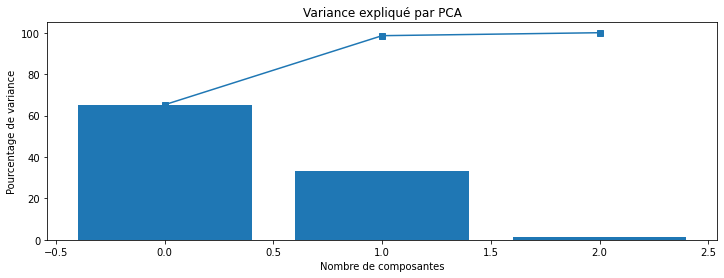

In [24]:

#appliquons PCA sur cette partie de dataframe

from sklearn.decomposition import PCA

pca = PCA()

segmentation_rfm_pca = pca.fit_transform(segmentation_rfm)

#Affichage graphique

fig = plt.figure(1, figsize=(12, 4))

plt.bar(range(len(pca.explained_variance_ratio_)),

        100*pca.explained_variance_ratio_)

plt.ylim(0, 1.05*100)

plt.plot(range(len(pca.explained_variance_ratio_)),

         100*np.cumsum(pca.explained_variance_ratio_), "s-")

plt.ylabel("Pourcentage de variance")

plt.xlabel("Nombre de composantes")

plt.title("Variance expliqué par PCA")

plt.show()

--> On atteint 100% de variance à partir de 3 composantes, nous allons donc garder toutes nos variables

### a. Recherche graphique de n-klusters : Elbow Method

Text(0, 0.5, 'cout du modèle(inertia)')

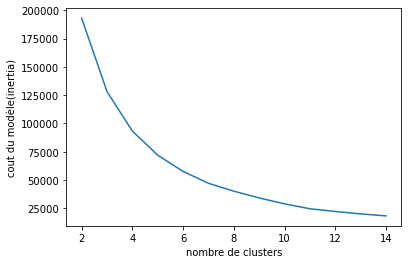

In [25]:
from sklearn.cluster import KMeans
inertia = []
k_range = range(2,15)
for k in k_range:
    model = KMeans(n_clusters = k).fit(segmentation_rfm)
    inertia.append(model.inertia_)

plt.plot(k_range, inertia)
plt.xlabel('nombre de clusters')
plt.ylabel('cout du modèle(inertia)')


--> D'après ce graphe, nous constatons que la zone de coude n'est pas très précise, mais elle indique comme même que le nombre idéal de clusters est entre 3 et 6.
Nous allons chercher le nombre de cluster idéal parmi 3,4, 5 ou 6 par une autre méthode mathématique: coefficient de silhouette.


### b. Recherche mathématique de n_clusters : coefficient de silhouette

    - Le coefficient de silhouette permet d'évaluer si un point x appartient au « bon » cluster : est-il proche des points du cluster auquel il appartient ? Est-il loin des autres points ?
    - Le coefficient de silhouette est compris entre -1 et 1, et d'autant plus proche de 1 que l'assignation de x à son cluster est satisfaisante.

In [26]:
# CODE SOURCE SCIKIT LEARN

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

def kmeans_inspection(X, range_n_clusters):

    for n_clusters in range_n_clusters:

        # Create a subplot with 1 row and 2 columns
        #fig, (ax1, ax2) = plt.subplots(1, 1)
        fig = plt.figure(figsize=(15, 10))
        ax1 = fig.gca()

        #fig.set_size_inches(18, 7)
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])

        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters )
        cluster_labels = clusterer.fit_predict(X)
        frame = pd.DataFrame(X)
        #pred = kmeans.predict(extend2_rfm)
        frame['cluster'] = cluster_labels
        print(
            "For n_clusters =", n_clusters,
            
            "\ntaille des clusters\n", 
            frame['cluster'].value_counts())

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)

        print(
            "\nFor n_clusters =", n_clusters,

            "The average silhouette_score is :",round(silhouette_avg, 3),
           )

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)
        y_lower = 10
        
        for i in range(n_clusters):

            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
            ith_cluster_silhouette_values.sort()
            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i
            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

For n_clusters = 3 
taille des clusters
 1    53016
0    39189
2     3355
Name: cluster, dtype: int64

For n_clusters = 3 The average silhouette_score is : 0.565
For n_clusters = 4 
taille des clusters
 0    52836
1    39189
2     3418
3      117
Name: cluster, dtype: int64

For n_clusters = 4 The average silhouette_score is : 0.571
For n_clusters = 5 
taille des clusters
 1    46718
0    36550
3     8986
2     3190
4      116
Name: cluster, dtype: int64

For n_clusters = 5 The average silhouette_score is : 0.629
For n_clusters = 6 
taille des clusters
 1    46718
0    36550
4     8952
2     2787
3      527
5       26
Name: cluster, dtype: int64

For n_clusters = 6 The average silhouette_score is : 0.643
For n_clusters = 7 
taille des clusters
 2    46718
0    20964
6    15586
1     8952
3     2787
5      527
4       26
Name: cluster, dtype: int64

For n_clusters = 7 The average silhouette_score is : 0.732


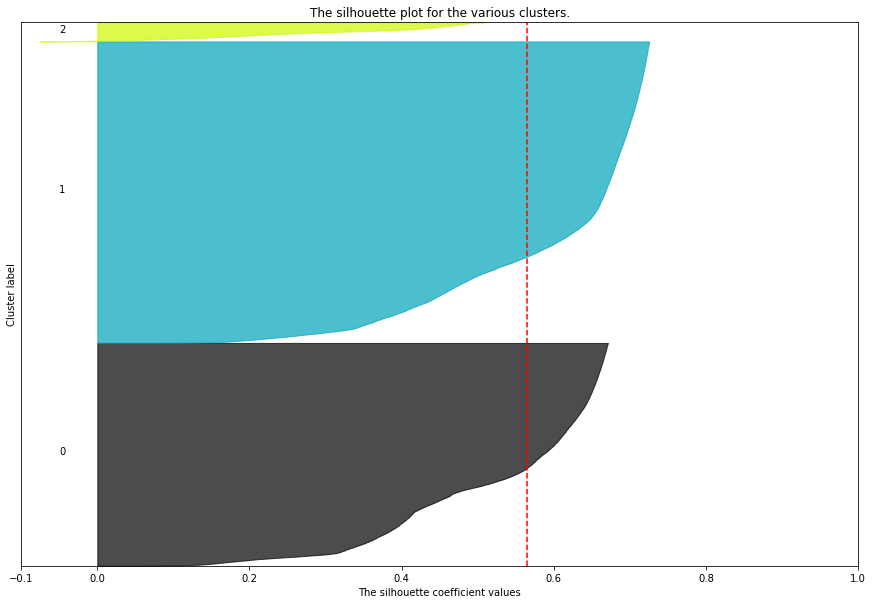

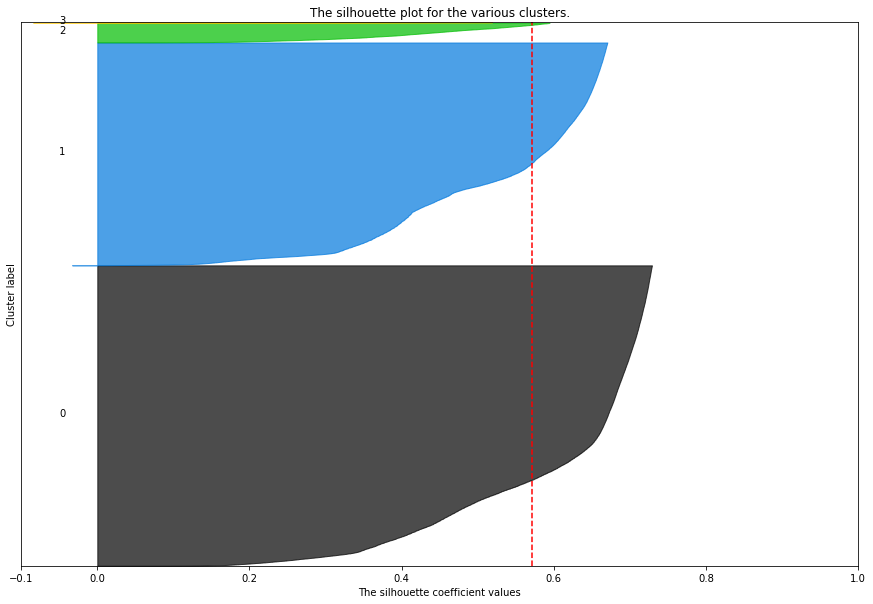

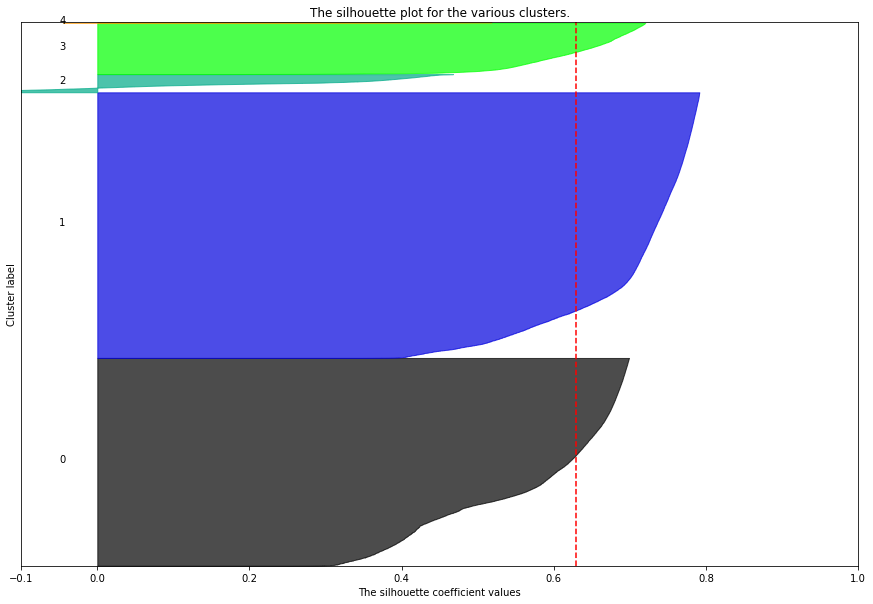

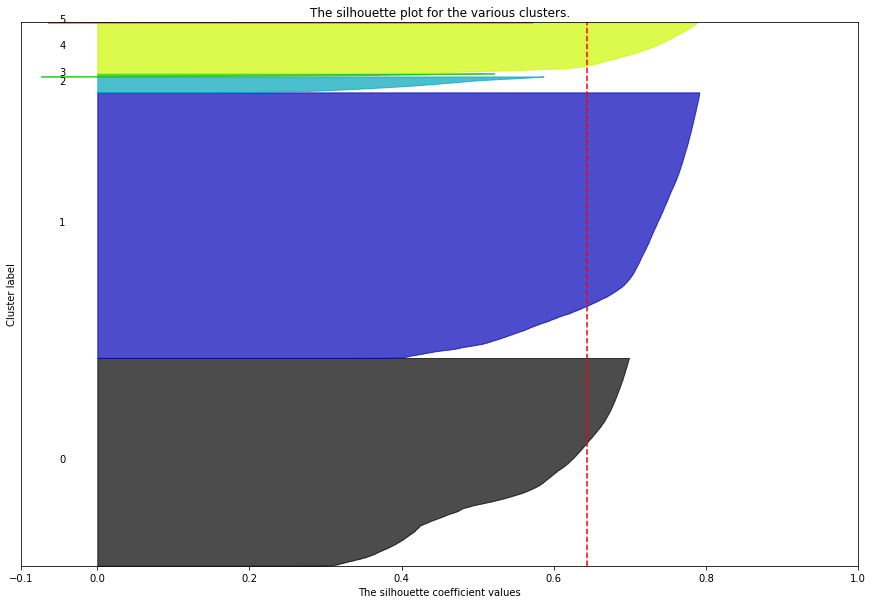

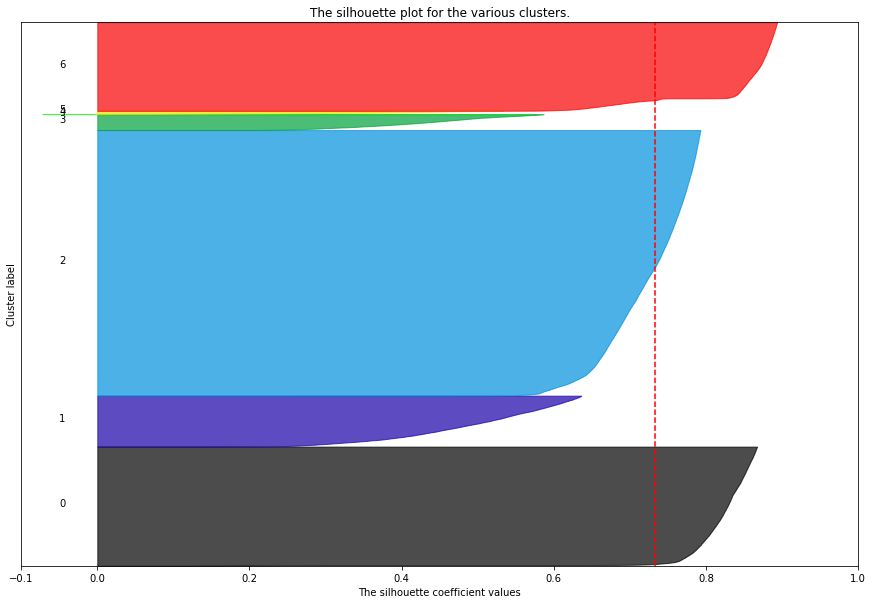

In [27]:
range_n_clusters = [3,4, 5, 6,7]
kmeans_inspection(segmentation_rfm, range_n_clusters)

**Interprétation:**

Nous remarquons que malgrès pour k= 6, on atteint le plus grand coefficient de silhouette. Malgrès celà, les clusters ne sont pas de tailles assez proches. Nous remarquons d'ailleur que dans ce cas, le cluster N°4 contient uniquement 96 clients.   
Nous allons essayer d'autres features. 


## Deuxième test: rajouter le feature 'distance_clientVendeur'

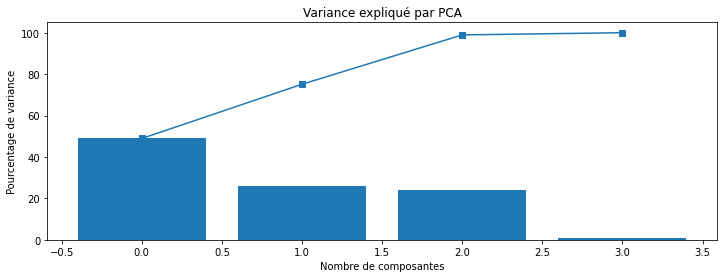

In [28]:
extend_rfm = df_agg[['frequence','recence','montant','distance_clientVendeur']]

#appliquon PCA
extend_rfm_pca = pca.fit_transform(extend_rfm)

#Affichage graphique
fig = plt.figure(1, figsize=(12, 4))
plt.bar(range(len(pca.explained_variance_ratio_)),
        100*pca.explained_variance_ratio_)
plt.ylim(0, 1.05*100)
plt.plot(range(len(pca.explained_variance_ratio_)),
         100*np.cumsum(pca.explained_variance_ratio_), "s-")
plt.ylabel("Pourcentage de variance")
plt.xlabel("Nombre de composantes")
plt.title("Variance expliqué par PCA")
plt.show()

On atteint 100% de variance expliquée lorsqu'on a 4 composantes , nous décidons de garder toutes les composantes.

### Recherche par la méthode d'elbow

In [29]:
#appliquer le modèle en précisant 0.99 de variance expliquée
model = PCA(n_components= 0.99)
extend_rfm_reduced = model.fit_transform(extend_rfm)

In [30]:
inertia = []
k_range = range(2,15)
for k in k_range:
    model = KMeans(n_clusters = k).fit(extend_rfm)
    inertia.append(model.inertia_)

Text(0, 0.5, 'cout du modèle(inertia)')

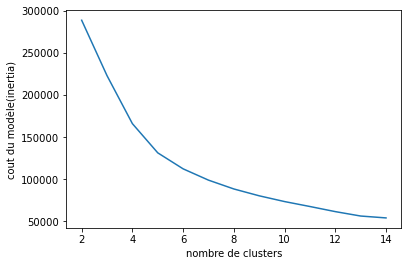

In [31]:
plt.plot(k_range, inertia)
plt.xlabel('nombre de clusters')
plt.ylabel('cout du modèle(inertia)')

Selon la méthode d'elbow, on constate que les clusters optimaux sont entre 3 et 5, soit 3, 4 ou 5 clusters. Nous allons les analyser en calculant le coefficient de silhouette.


### Coefficient de silhouette

For n_clusters = 4 
taille des clusters
 0    46941
3    34072
1    11444
2     3103
Name: cluster, dtype: int64

For n_clusters = 4 The average silhouette_score is : 0.381
For n_clusters = 5 
taille des clusters
 2    46473
0    33966
4    11369
1     3635
3      117
Name: cluster, dtype: int64

For n_clusters = 5 The average silhouette_score is : 0.387
For n_clusters = 6 
taille des clusters
 0    42267
2    30316
4    11096
1    10163
5     1623
3       95
Name: cluster, dtype: int64

For n_clusters = 6 The average silhouette_score is : 0.407
For n_clusters = 7 
taille des clusters
 6    27899
2    27018
5    18109
1    10796
0    10020
4     1624
3       94
Name: cluster, dtype: int64

For n_clusters = 7 The average silhouette_score is : 0.334


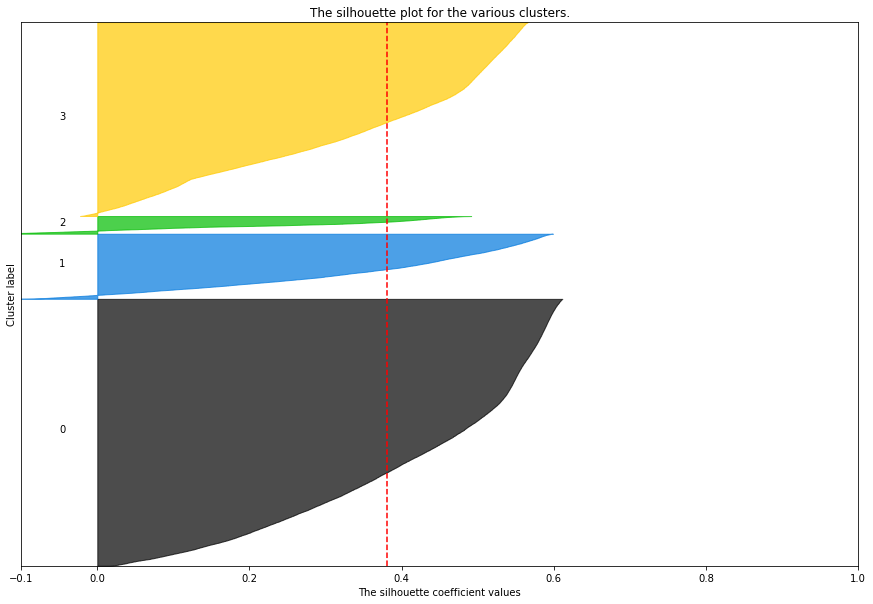

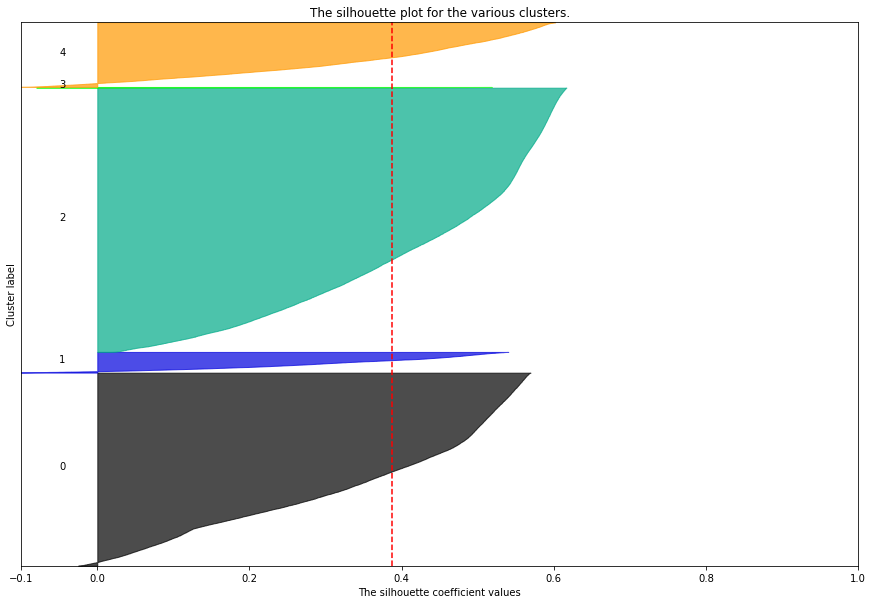

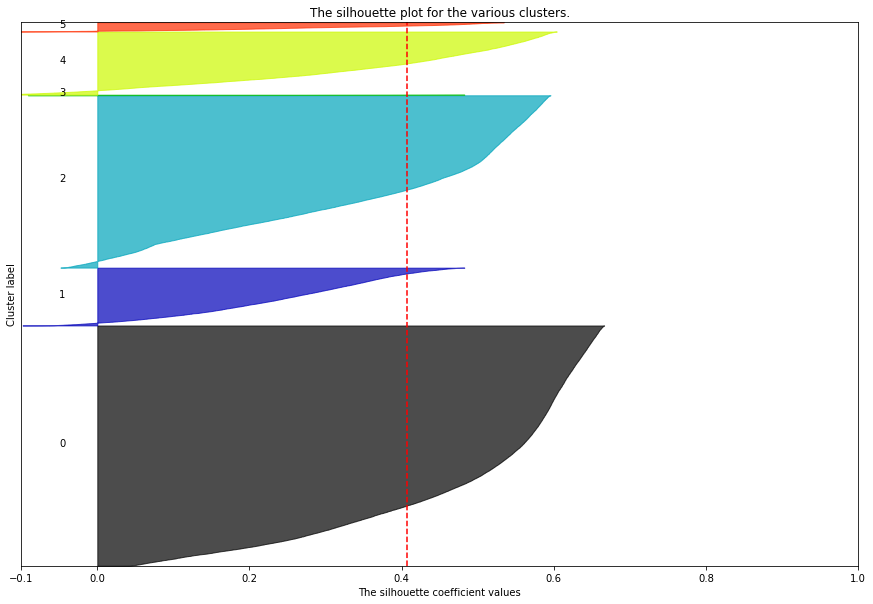

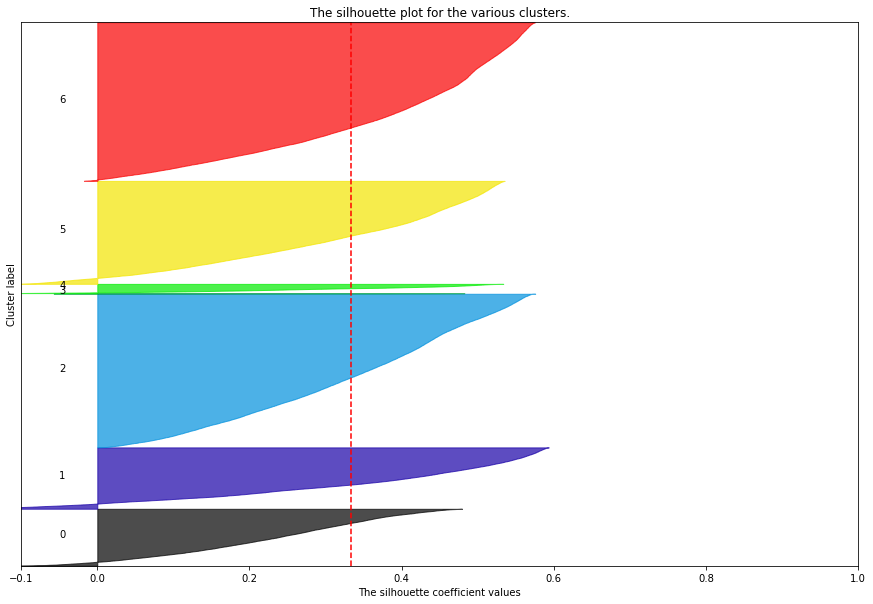

In [32]:
range_n_clusters = [4,5, 6,7]
kmeans_inspection(extend_rfm_reduced, range_n_clusters)

For n_clusters = 7 
taille des clusters
 4    27959
0    26987
5    18077
6    10798
1    10021
3     1624
2       94
Name: cluster, dtype: int64

For n_clusters = 7 The average silhouette_score is : 0.334


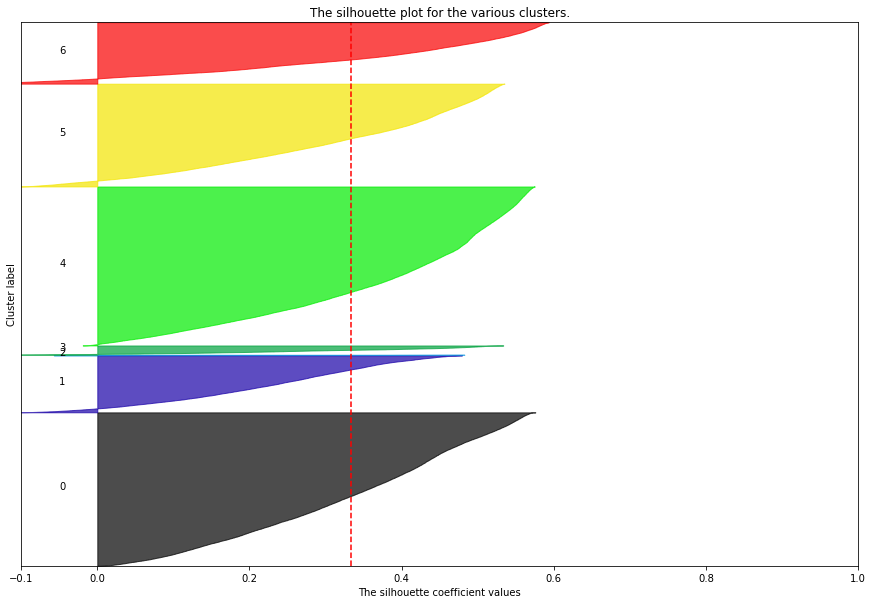

In [33]:
range_n_clusters = [7]
kmeans_inspection(extend_rfm_reduced, range_n_clusters)

Nous remarquons que les coefficients de silhouette sont un peu plus distinct par rapport au test précédent ave un feature de moins. Dans ce cas, nous pouvons dire que kluster = 3 est plus optimal. Néanmoins, le coefficient de silhouette 0.378 est encore assez faible. Rappelons qu'on souhaite qu'il soit plus proche de 1.

Nous allons refaire la recherche en rajoutant d'autres features.


## Troisième test: rajouter le feature 'review_score'

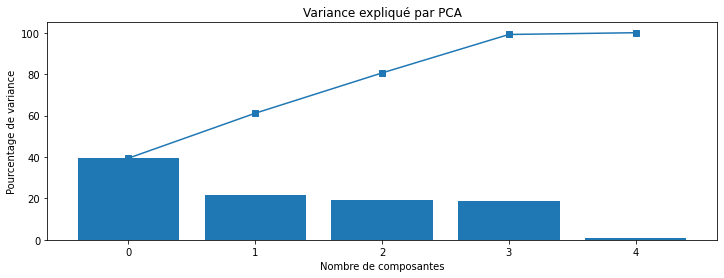

In [34]:
extend2_rfm = df_agg[['frequence','recence','montant','distance_clientVendeur','review_score']]

#appliquon PCA
extend2_rfm_pca = pca.fit_transform(extend2_rfm)

#Affichage graphique
fig = plt.figure(1, figsize=(12, 4))
plt.bar(range(len(pca.explained_variance_ratio_)),
        100*pca.explained_variance_ratio_)
plt.ylim(0, 1.05*100)
plt.plot(range(len(pca.explained_variance_ratio_)),
         100*np.cumsum(pca.explained_variance_ratio_), "s-")
plt.ylabel("Pourcentage de variance")
plt.xlabel("Nombre de composantes")
plt.title("Variance expliqué par PCA")
plt.show()

Nous décidons de garder toutes nos composantes

### Elbow method

In [35]:
inertia = []
k_range = range(2,15)
for k in k_range:
    model = KMeans(n_clusters = k).fit(extend2_rfm)
    inertia.append(model.inertia_)

Text(0, 0.5, 'cout du modèle(inertia)')

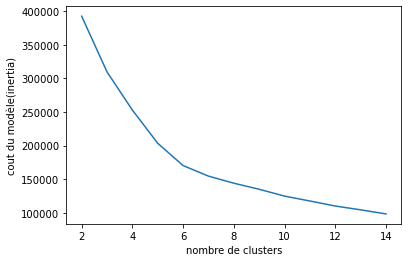

In [36]:
plt.plot(k_range, inertia)
plt.xlabel('nombre de clusters')
plt.ylabel('cout du modèle(inertia)')

### Coefficient de silhouette

For n_clusters = 5 
taille des clusters
 4    39157
1    28923
3    15232
0    10382
2     1866
Name: cluster, dtype: int64

For n_clusters = 5 The average silhouette_score is : 0.509
For n_clusters = 6 
taille des clusters
 3    38749
1    28552
0    14705
2    10343
5     3095
4      116
Name: cluster, dtype: int64

For n_clusters = 6 The average silhouette_score is : 0.49
For n_clusters = 7 
taille des clusters
 1    38587
4    28552
3    14705
0    10343
6     2809
2      537
5       27
Name: cluster, dtype: int64

For n_clusters = 7 The average silhouette_score is : 0.527


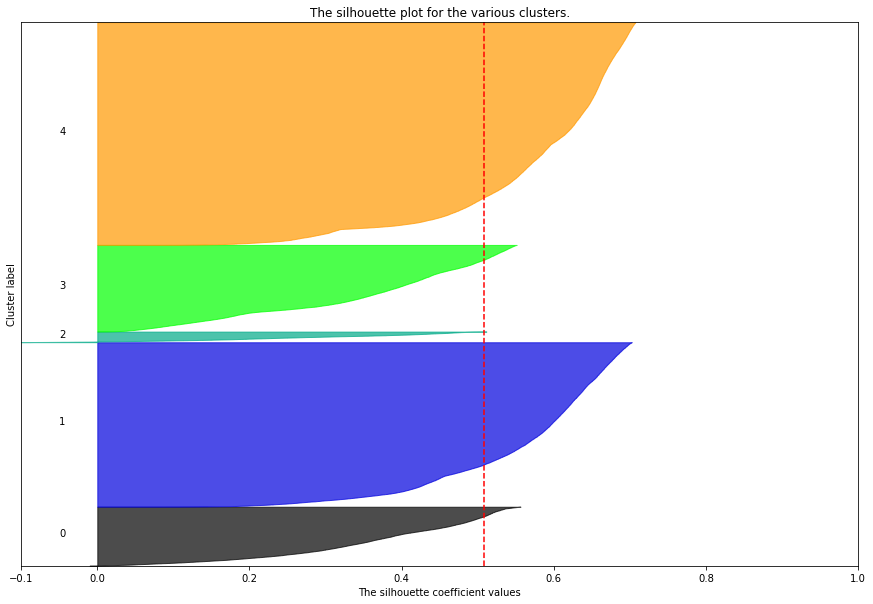

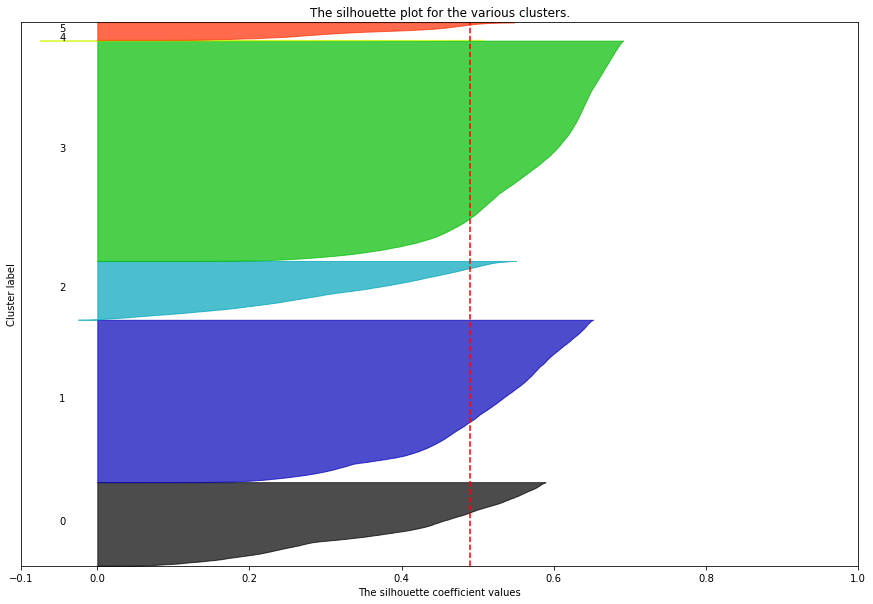

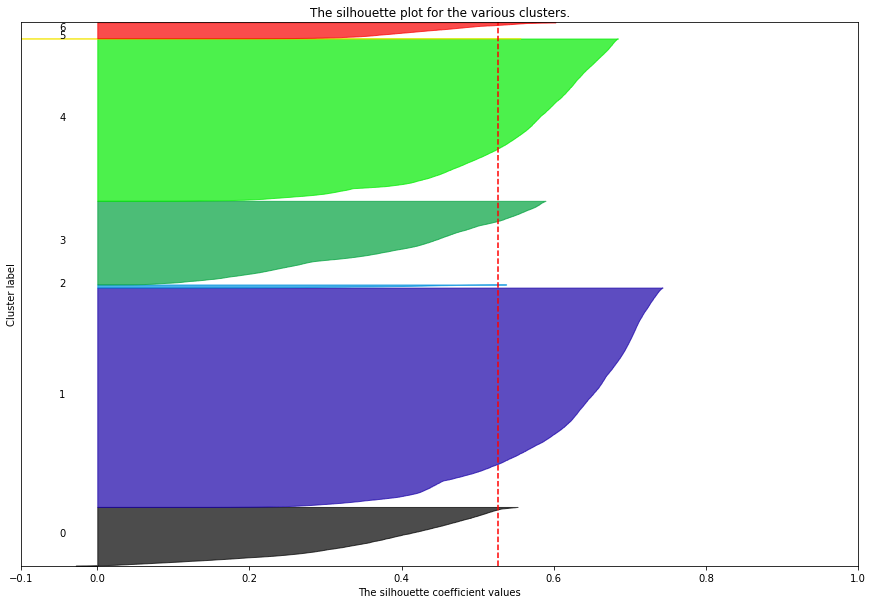

In [37]:
range_n_clusters = [5,6,7]
kmeans_inspection(extend2_rfm, range_n_clusters)

--> Le meilleur coefficient de silhouette est pour n_clusters= 5. Essayons la recherche avec tous les features.

## Quatrième test: Rajouter le feature 'reactivité'

Text(0, 0.5, 'cout du modèle(inertia)')

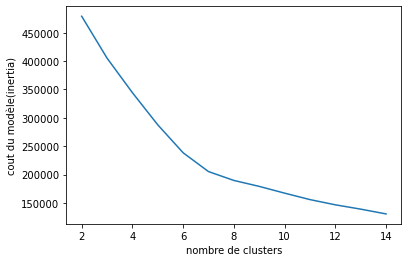

In [38]:
df_new = df_agg[['review_score','reactivite','distance_clientVendeur', 'frequence', 'montant','recence']]

inertia = []
k_range = range(2,15)
for k in k_range:
    model = KMeans(n_clusters = k).fit(df_new)
    inertia.append(model.inertia_)

plt.plot(k_range, inertia)
plt.xlabel('nombre de clusters')
plt.ylabel('cout du modèle(inertia)')

For n_clusters = 6 
taille des clusters
 2    39106
0    28825
1    15196
5    10366
3     1864
4      203
Name: cluster, dtype: int64

For n_clusters = 6 The average silhouette_score is : 0.476
For n_clusters = 7 
taille des clusters
 2    38539
0    28666
3    14775
1    10351
6     2910
4      203
5      116
Name: cluster, dtype: int64

For n_clusters = 7 The average silhouette_score is : 0.469
For n_clusters = 8 
taille des clusters
 1    38458
3    28590
0    14747
4    10333
2     2906
6      331
7      116
5       79
Name: cluster, dtype: int64

For n_clusters = 8 The average silhouette_score is : 0.476
For n_clusters = 9 
taille des clusters
 1    28327
2    24600
0    14739
8    13866
5    10284
6     3218
7      331
4      116
3       79
Name: cluster, dtype: int64

For n_clusters = 9 The average silhouette_score is : 0.474


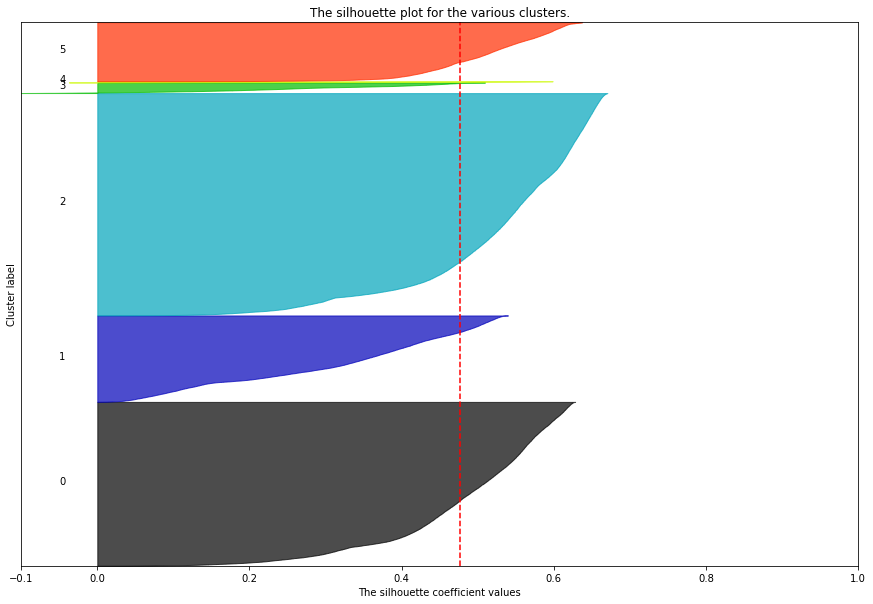

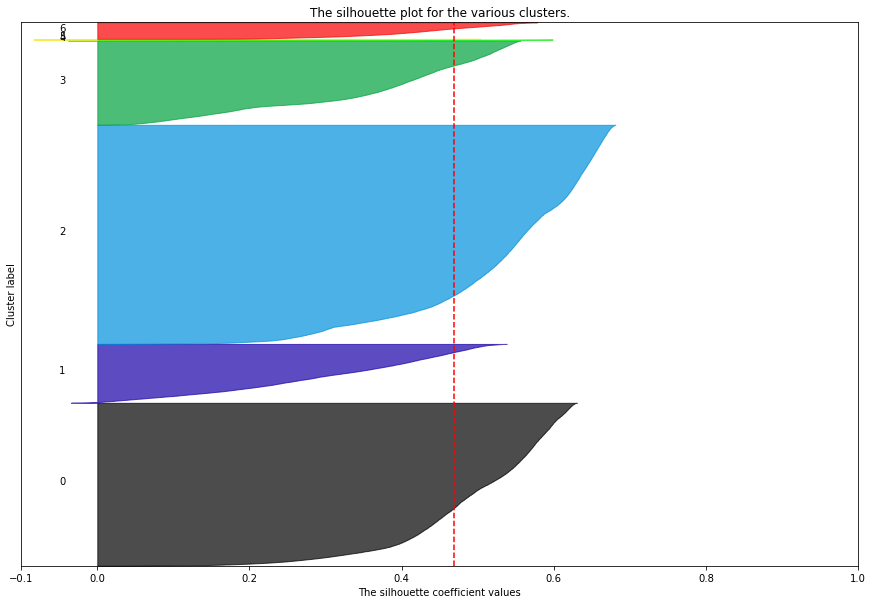

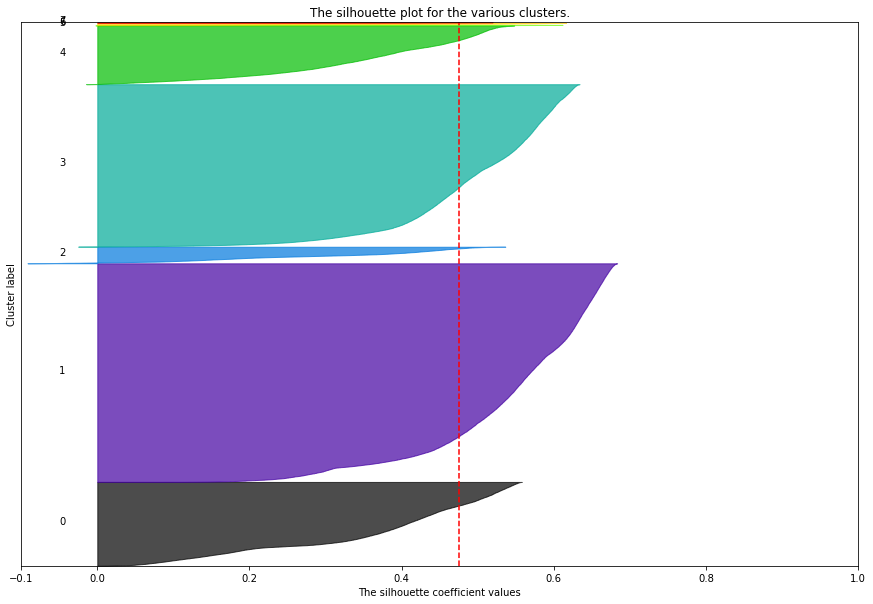

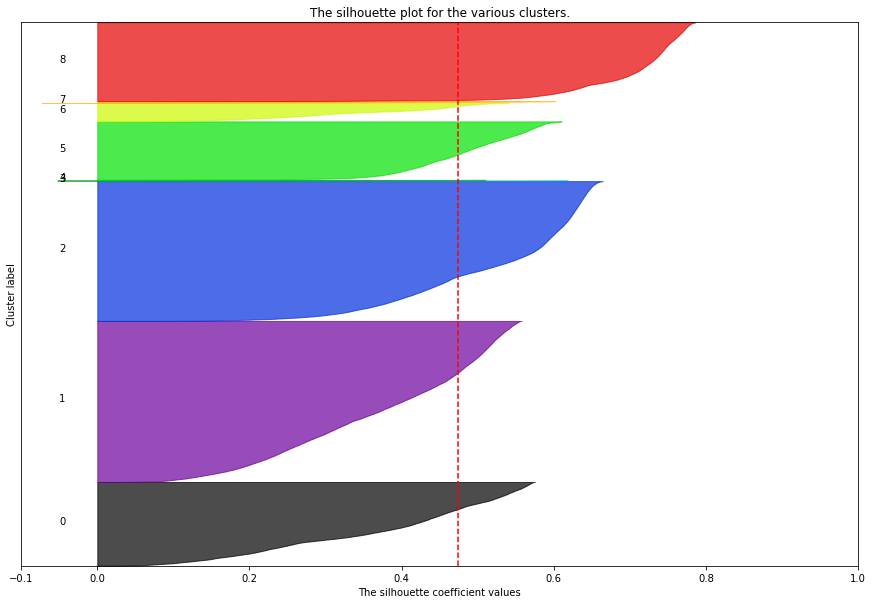

In [39]:
range_n_clusters = [ 6,7,8,9 ]
kmeans_inspection(df_new, range_n_clusters)

Text(0, 0.5, 'cout du modèle(inertia)')

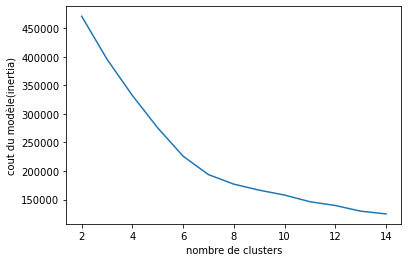

In [40]:
df_new = df_agg[['review_score','evaluateur','distance_clientVendeur', 'frequence', 'montant','recence']]

inertia = []
k_range = range(2,15)
for k in k_range:
    model = KMeans(n_clusters = k).fit(df_new)
    inertia.append(model.inertia_)

plt.plot(k_range, inertia)
plt.xlabel('nombre de clusters')
plt.ylabel('cout du modèle(inertia)')

For n_clusters = 6 
taille des clusters
 4    39179
2    28936
1    15200
0    10386
5     1853
3        6
Name: cluster, dtype: int64

For n_clusters = 6 The average silhouette_score is : 0.489
For n_clusters = 7 
taille des clusters
 1    38981
0    28936
2    15200
6    10386
3     1954
5       97
4        6
Name: cluster, dtype: int64

For n_clusters = 7 The average silhouette_score is : 0.434
For n_clusters = 8 
taille des clusters
 0    34622
2    27591
7    14270
1    10386
3     6801
5     1787
6       97
4        6
Name: cluster, dtype: int64

For n_clusters = 8 The average silhouette_score is : 0.535


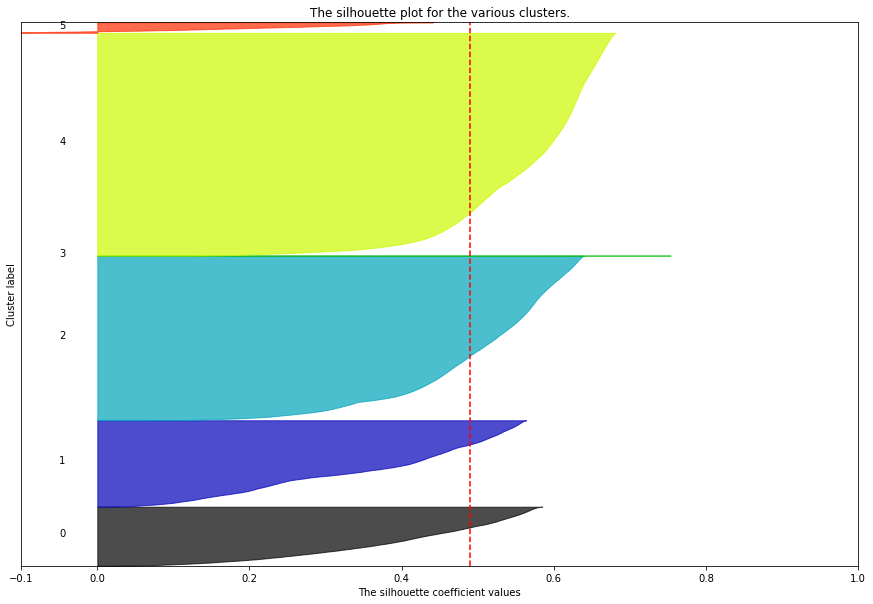

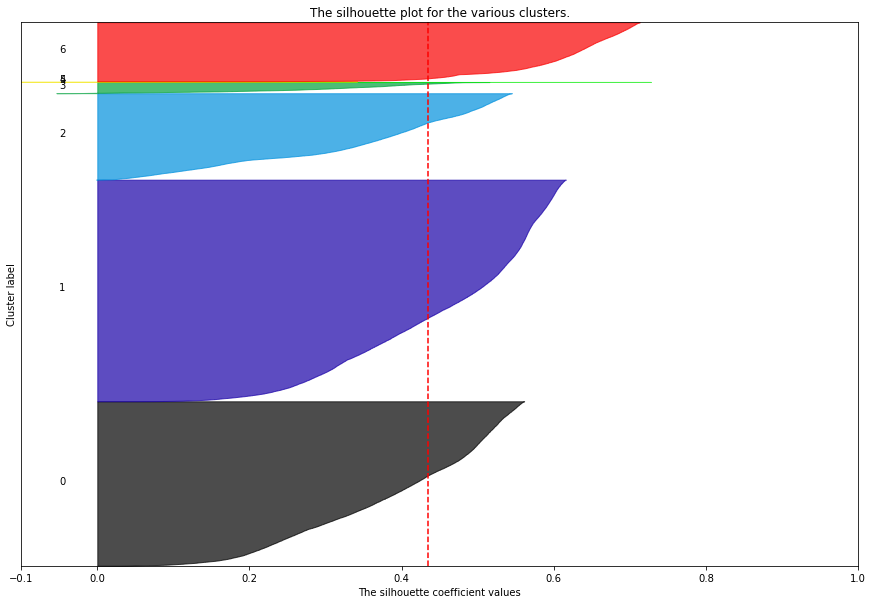

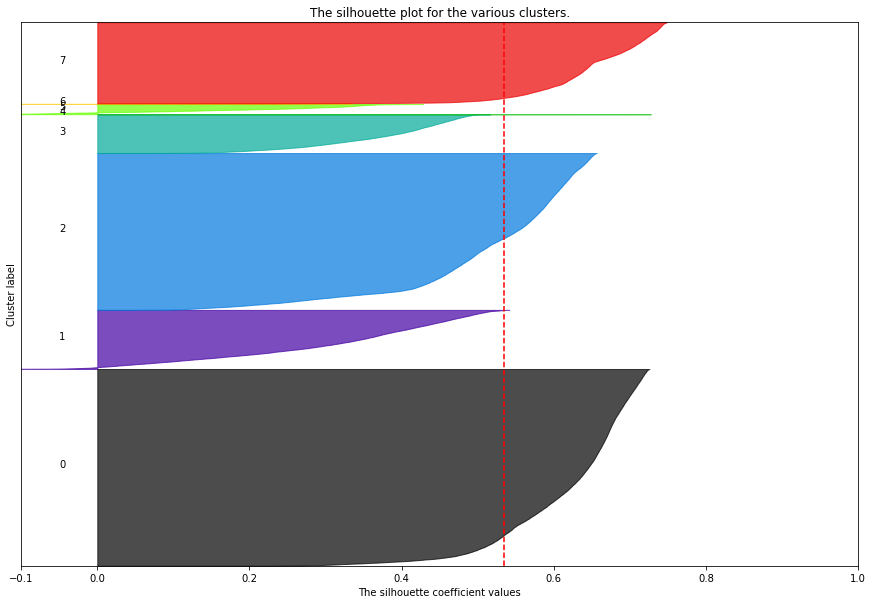

In [41]:
range_n_clusters = [ 6,7,8 ]
kmeans_inspection(df_new, range_n_clusters)

### Cinquième test: tester la totalité des features à la base numériques sauf les variables qualitatives encodées

In [42]:
df_agg.columns

Index(['customer_unique_id', 'review_score', 'payment_sequential',
       'payment_installments', 'payment_value', 'freight_value', 'reactivite',
       'distance_clientVendeur', 'frequence', 'recence', 'montant',
       'evaluateur', 'pay_boleto', 'pay_credit_card', 'pay_debit_card',
       'pay_voucher', 'categ_divers', 'categ_lifestyle', 'categ_loisir',
       'categ_maison', 'categ_mode', 'categ_nourriture', 'categ_outils',
       'categ_service', 'categ_sport', 'categ_technology'],
      dtype='object')

In [43]:
vars_to_compress = df_agg.iloc[:,1:12]
vars_to_compress

,review_score,payment_sequential,payment_installments,payment_value,freight_value,reactivite,distance_clientVendeur,frequence,recence,montant,evaluateur
0,0.682278,-0.120737,1.902414,-0.111300,-0.519718,0.142454,-0.831009,-0.280732,-0.835493,-0.207978,0.019412
1,-0.062541,-0.120737,-0.710120,-0.289857,-0.754486,-0.262115,-0.979635,-0.280732,-0.815901,-0.483531,-0.147992
2,-0.807360,-0.120737,1.902414,-0.197971,-0.189397,-0.160973,-0.146810,-0.280732,1.946529,-0.291792,-0.147992
3,-0.062541,-0.120737,0.409538,-0.264282,-0.163452,-0.160973,3.159341,-0.280732,0.535926,-0.405574,0.019412
4,0.682278,-0.120737,1.155976,-0.025703,-0.210279,0.142454,-0.756966,-0.280732,0.320418,-0.152710,-0.147992
...,...,...,...,...,...,...,...,...,...,...,...
95555,0.682278,-0.120737,2.648853,6.104096,14.459275,0.142454,2.343365,0.894180,1.358778,1.776995,-0.147992
95556,-0.062541,-0.120737,-0.710120,-0.200524,-0.033095,0.243596,1.553428,-0.280732,0.150623,-0.295014,-0.147992
95557,0.682278,-0.120737,-0.710120,-0.157126,0.148518,-0.059830,1.551678,-0.280732,2.148976,-0.247141,-0.147992
95558,0.682278,-0.120737,0.782757,-0.124079,-0.096375,-0.059830,0.056519,-0.280732,-0.783248,-0.218023,0.019412


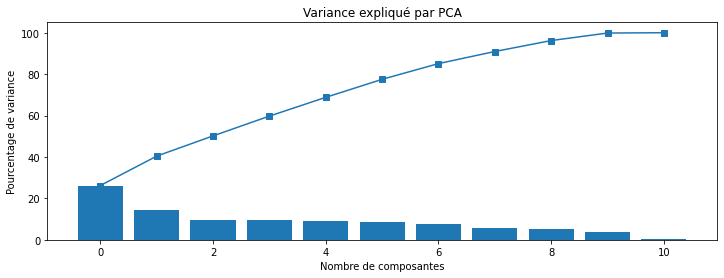

In [44]:
# Réduction dimmensionnelle avec 'Principal Component Analysis'

pca = PCA()
df_pca = pca.fit_transform(vars_to_compress)

# Affichage graphique
fig = plt.figure(1, figsize=(12, 4))
plt.bar(range(len(pca.explained_variance_ratio_)),
        100*pca.explained_variance_ratio_)

plt.ylim(0, 1.05*100)
plt.plot(range(len(pca.explained_variance_ratio_)),
         100*np.cumsum(pca.explained_variance_ratio_), "s-")

plt.ylabel("Pourcentage de variance")
plt.xlabel("Nombre de composantes")
plt.title("Variance expliqué par PCA")
plt.show()

--> Je décide de garder toutes les composantes

### Elbow method

In [45]:
inertia = []
k_range = range(2,15)
for k in k_range:
    model = KMeans(n_clusters = k).fit(vars_to_compress)
    inertia.append(model.inertia_)

Text(0, 0.5, 'cout du modèle(inertia)')

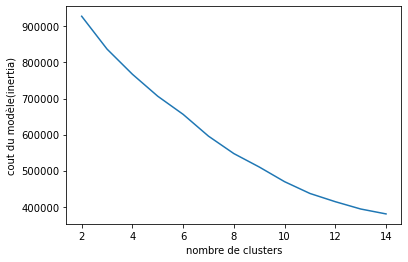

In [46]:
plt.plot(k_range, inertia)
plt.xlabel('nombre de clusters')
plt.ylabel('cout du modèle(inertia)')

### Coefficient de silhouette

For n_clusters = 4 
taille des clusters
 2    76096
1    16027
0     3372
3       65
Name: cluster, dtype: int64

For n_clusters = 4 The average silhouette_score is : 0.34
For n_clusters = 5 
taille des clusters
 1    60092
2    17526
0    14524
3     3353
4       65
Name: cluster, dtype: int64

For n_clusters = 5 The average silhouette_score is : 0.27
For n_clusters = 6 
taille des clusters
 0    59974
2    17643
3    14481
1     3230
5      199
4       33
Name: cluster, dtype: int64

For n_clusters = 6 The average silhouette_score is : 0.349
For n_clusters = 7 
taille des clusters
 3    34945
2    25087
1    17642
4    14482
0     3140
6      199
5       65
Name: cluster, dtype: int64

For n_clusters = 7 The average silhouette_score is : 0.25
For n_clusters = 8 
taille des clusters
 0    35130
2    26061
6    16629
1    14284
5     3123
7      199
3      128
4        6
Name: cluster, dtype: int64

For n_clusters = 8 The average silhouette_score is : 0.369
For n_clusters = 9 
taille d

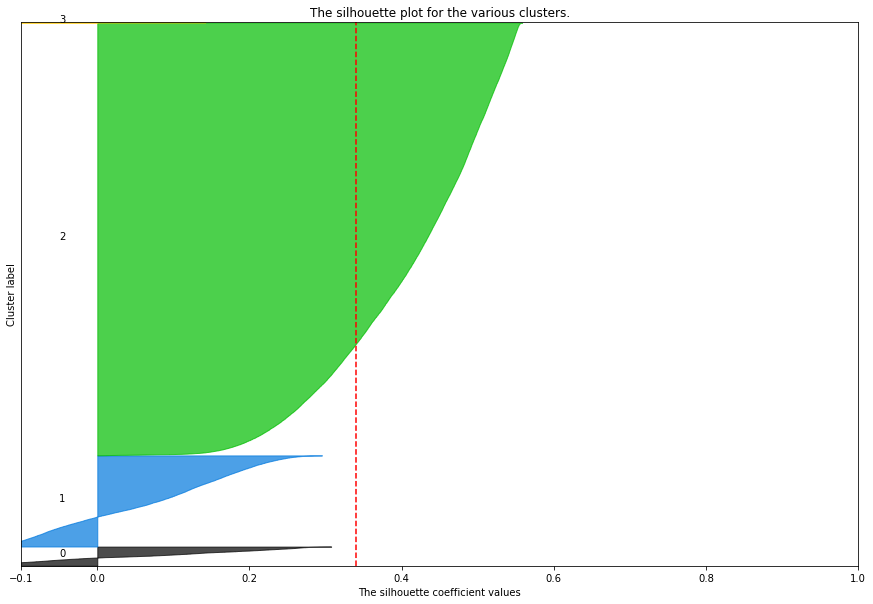

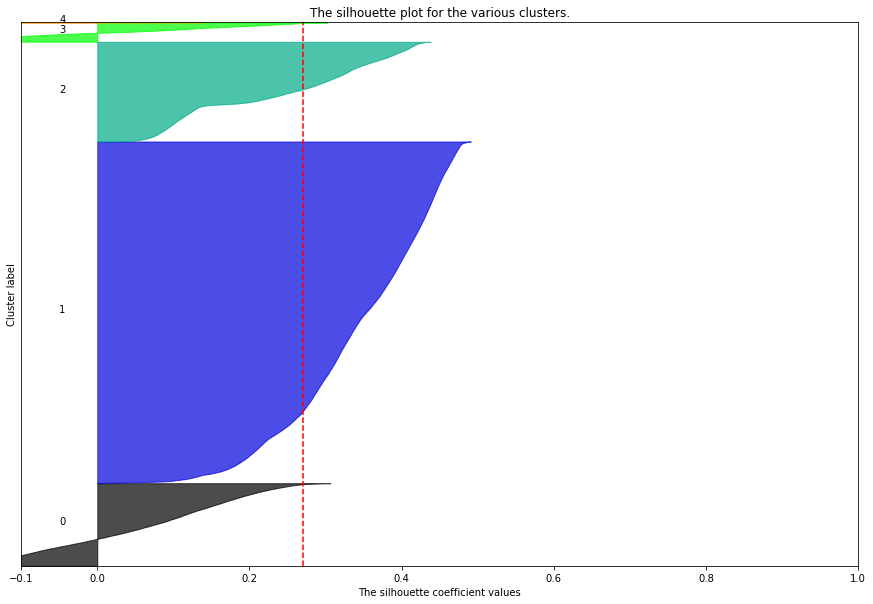

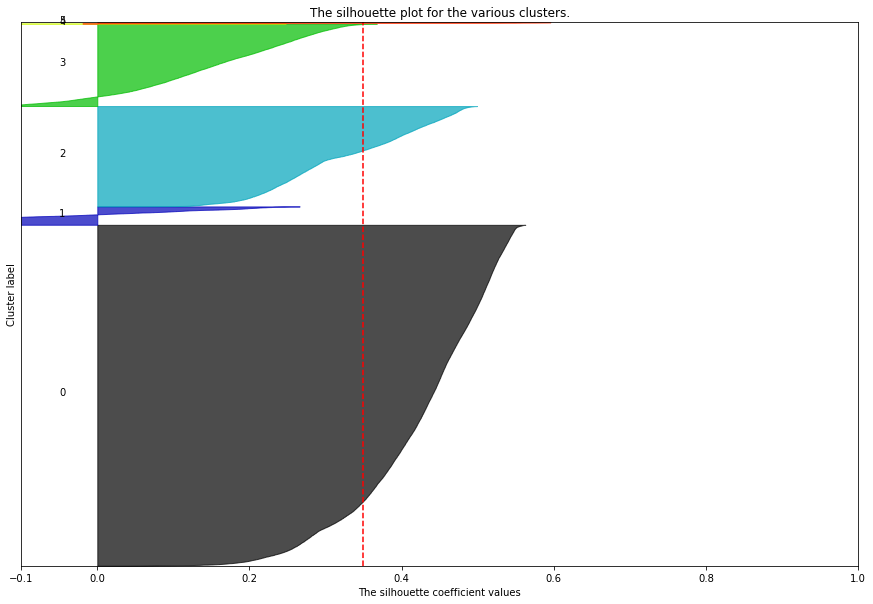

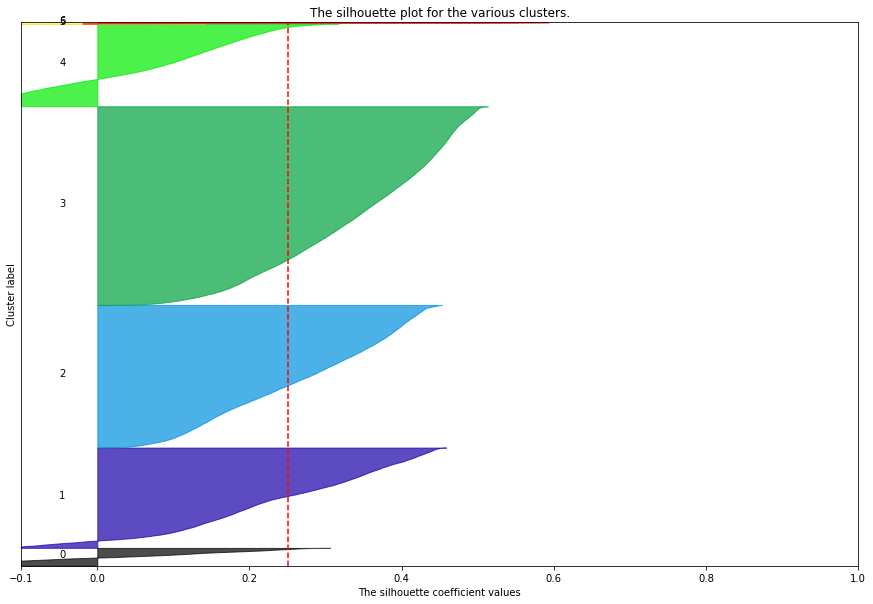

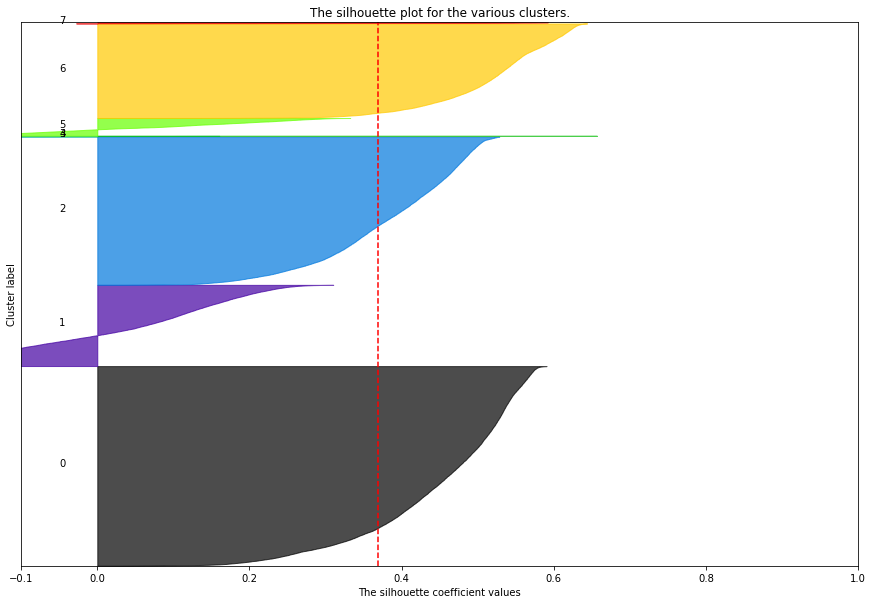

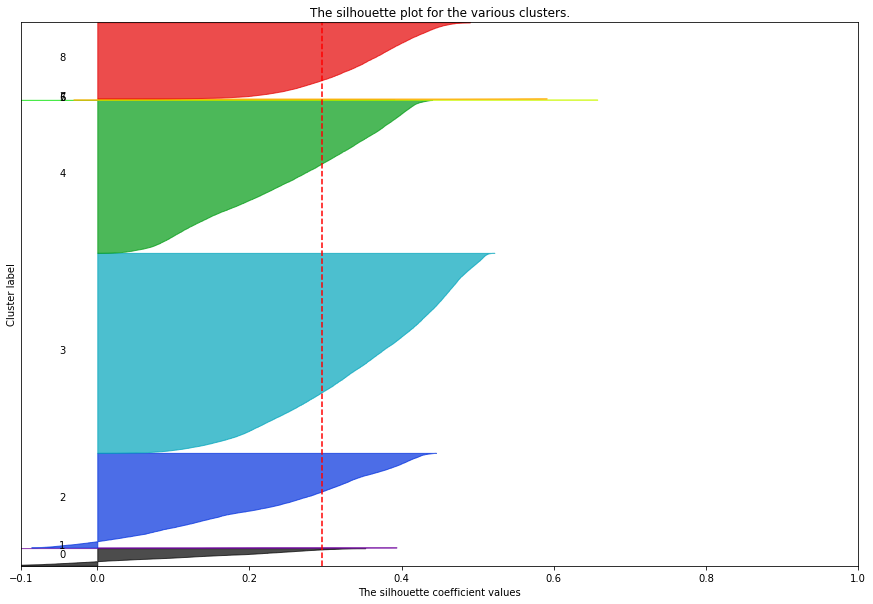

In [47]:
range_n_clusters = [4, 5, 6, 7,8,9]
kmeans_inspection(vars_to_compress, range_n_clusters)

## Sixième approche: tester la totalité des features y compris les variables qualitatives encodées

In [48]:
#selectionner la totalité des features
vars_to_compress = df_agg.iloc[:,1::]
vars_to_compress

,review_score,payment_sequential,payment_installments,payment_value,freight_value,reactivite,distance_clientVendeur,frequence,recence,montant,evaluateur,pay_boleto,pay_credit_card,pay_debit_card,pay_voucher,categ_divers,categ_lifestyle,categ_loisir,categ_maison,categ_mode,categ_nourriture,categ_outils,categ_service,categ_sport,categ_technology
0,0.682278,-0.120737,1.902414,-0.111300,-0.519718,0.142454,-0.831009,-0.280732,-0.835493,-0.207978,0.019412,-0.415904,0.116480,-0.115387,-0.116414,-0.347926,-0.407869,-0.196817,0.649523,-0.168385,-0.083428,-0.096542,-0.187066,-0.253002,-0.354290
1,-0.062541,-0.120737,-0.710120,-0.289857,-0.754486,-0.262115,-0.979635,-0.280732,-0.815901,-0.483531,-0.147992,-0.415904,0.116480,-0.115387,-0.116414,-0.347926,1.561013,-0.196817,-0.490309,-0.168385,-0.083428,-0.096542,-0.187066,-0.253002,-0.354290
2,-0.807360,-0.120737,1.902414,-0.197971,-0.189397,-0.160973,-0.146810,-0.280732,1.946529,-0.291792,-0.147992,-0.415904,0.116480,-0.115387,-0.116414,1.953438,-0.407869,-0.196817,-0.490309,-0.168385,-0.083428,-0.096542,-0.187066,-0.253002,-0.354290
3,-0.062541,-0.120737,0.409538,-0.264282,-0.163452,-0.160973,3.159341,-0.280732,0.535926,-0.405574,0.019412,-0.415904,0.116480,-0.115387,-0.116414,-0.347926,-0.407869,-0.196817,-0.490309,-0.168385,-0.083428,-0.096542,-0.187066,-0.253002,1.591117
4,0.682278,-0.120737,1.155976,-0.025703,-0.210279,0.142454,-0.756966,-0.280732,0.320418,-0.152710,-0.147992,-0.415904,0.116480,-0.115387,-0.116414,-0.347926,-0.407869,-0.196817,-0.490309,-0.168385,-0.083428,-0.096542,-0.187066,-0.253002,1.591117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95555,0.682278,-0.120737,2.648853,6.104096,14.459275,0.142454,2.343365,0.894180,1.358778,1.776995,-0.147992,-0.415904,1.458509,-0.115387,-0.116414,-0.347926,3.529896,-0.196817,-0.490309,-0.168385,-0.083428,-0.096542,-0.187066,-0.253002,-0.354290
95556,-0.062541,-0.120737,-0.710120,-0.200524,-0.033095,0.243596,1.553428,-0.280732,0.150623,-0.295014,-0.147992,-0.415904,0.116480,-0.115387,-0.116414,-0.347926,-0.407869,3.636814,-0.490309,-0.168385,-0.083428,-0.096542,-0.187066,-0.253002,-0.354290
95557,0.682278,-0.120737,-0.710120,-0.157126,0.148518,-0.059830,1.551678,-0.280732,2.148976,-0.247141,-0.147992,-0.415904,0.116480,-0.115387,-0.116414,1.953438,-0.407869,-0.196817,-0.490309,-0.168385,-0.083428,-0.096542,-0.187066,-0.253002,-0.354290
95558,0.682278,-0.120737,0.782757,-0.124079,-0.096375,-0.059830,0.056519,-0.280732,-0.783248,-0.218023,0.019412,-0.415904,0.116480,-0.115387,-0.116414,-0.347926,1.561013,-0.196817,-0.490309,-0.168385,-0.083428,-0.096542,-0.187066,-0.253002,-0.354290


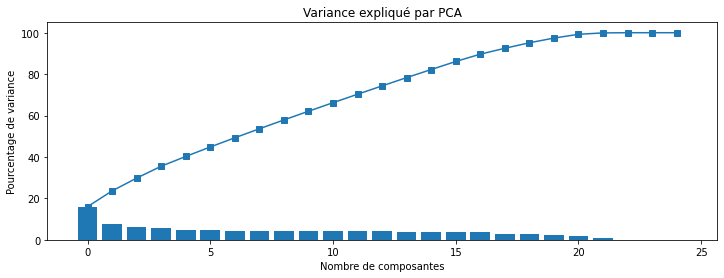

In [49]:
# Réduction dimmensionnelle avec 'Principal Component Analysis'
pca = PCA()
df_pca = pca.fit_transform(vars_to_compress)

# Affichage graphique
fig = plt.figure(1, figsize=(12, 4))
plt.bar(range(len(pca.explained_variance_ratio_)),
        100*pca.explained_variance_ratio_)

plt.ylim(0, 1.05*100)
plt.plot(range(len(pca.explained_variance_ratio_)),
         100*np.cumsum(pca.explained_variance_ratio_), "s-")

plt.ylabel("Pourcentage de variance")
plt.xlabel("Nombre de composantes")
plt.title("Variance expliqué par PCA")
plt.show()

--> Nous atteignons 100% de variance cumulée à partir de 22 composantes. Nous allons donc compresser nos données

In [50]:
#appliquer le modèle en précisant 0.99 de variance expliquée
model = PCA(n_components= 0.99)
df_agg_reduced = model.fit_transform(vars_to_compress)

In [51]:
#verifier le nombre de composantes après compression
model.n_components_

21

In [52]:
df_agg_reduced.shape

(95560, 21)

### Méthode Elbow

In [53]:
inertia = []
k_range = range(2,15)
for k in k_range:
    model = KMeans(n_clusters = k).fit(vars_to_compress)
    inertia.append(model.inertia_)

Text(0, 0.5, 'cout du modèle(inertia)')

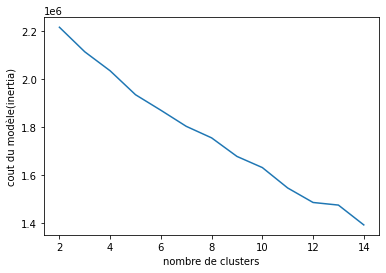

In [54]:
plt.plot(k_range, inertia)
plt.xlabel('nombre de clusters')
plt.ylabel('cout du modèle(inertia)')

### Coefficient de silhouette

For n_clusters = 4 
taille des clusters
 2    71987
0    20304
1     3197
3       72
Name: cluster, dtype: int64

For n_clusters = 4 The average silhouette_score is : 0.187
For n_clusters = 5 
taille des clusters
 0    52203
4    20237
3    20032
2     3027
1       61
Name: cluster, dtype: int64

For n_clusters = 5 The average silhouette_score is : 0.239
For n_clusters = 6 
taille des clusters
 0    52201
4    20084
5    18696
2     3013
1     1505
3       61
Name: cluster, dtype: int64

For n_clusters = 6 The average silhouette_score is : 0.285


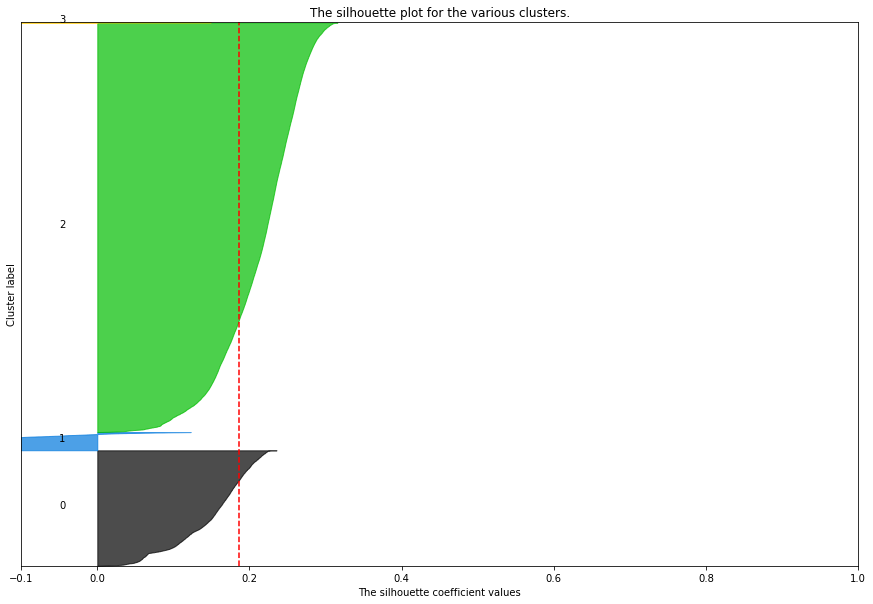

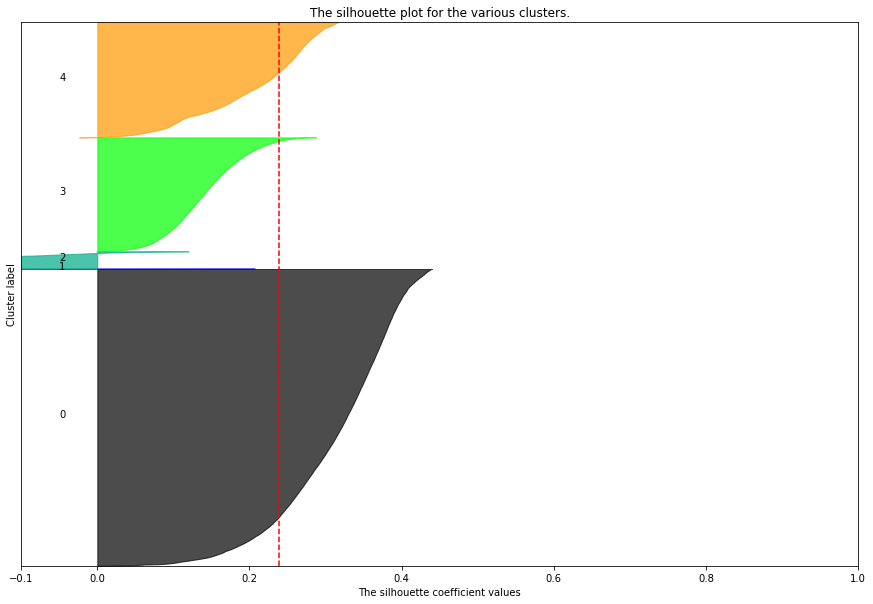

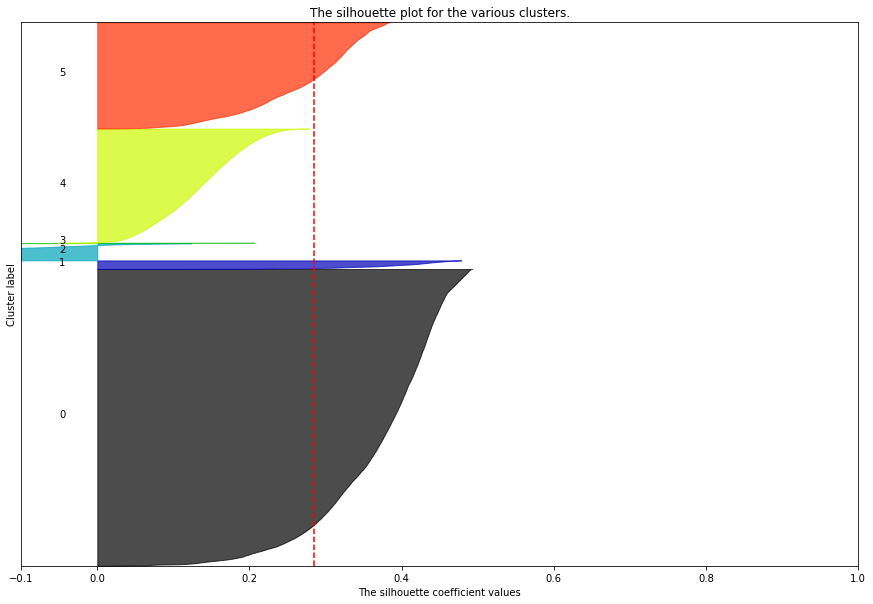

In [55]:
range_n_clusters = [4,5, 6]
kmeans_inspection(vars_to_compress, range_n_clusters)

## Choix final du nombre de clusters K

Après plusieurs tests effectués, Nous choisissons les features qui nous permettent d'assurer un compromis entre coefficient de silhouette et nombre de clients dans chaque cluster. Nous choisissons donc de travailler avec les features : 'frequence','recence','montant','distance_clientVendeur','review_score'. Le nombre de cluster choisi est K=5 (troisième test). 

## Etude des profils des clients selon les clusters

In [56]:
#entrainer KMMeans avec k = 5
final_features= df_agg[['frequence','recence','montant','distance_clientVendeur','review_score']]
model = KMeans(n_clusters=5 )
cluster_labels = model.fit_predict(final_features)
cluster_labels
frame = pd.DataFrame(final_features)
#pred = kmeans.predict(extend2_rfm)
frame['cluster'] = cluster_labels

In [57]:
#séparer les données des clusters
df_cluster0 = final_features[final_features['cluster']==0]
df_cluster1 = final_features[final_features['cluster']==1]
df_cluster2 = final_features[final_features['cluster']==2]
df_cluster3 = final_features[final_features['cluster']==3]
df_cluster4 = final_features[final_features['cluster']==4]

**Cluster 1**

/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/se

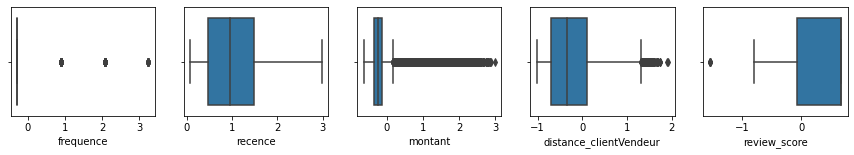

In [58]:
#boxplots
fig = plt.figure(1, figsize=(15, 2))

# Boxplot de la variable Frequence
plt.subplot(151)
sns.boxplot(df_cluster0["frequence"], orient="vertical")

# Boxplot de la variable recence
plt.subplot(152)
sns.boxplot(df_cluster0["recence"], orient="vertical")

# Boxplot de la variable Monetary
plt.subplot(153)
sns.boxplot(df_cluster0["montant"], orient="vertical")

# Boxplot de la variable distance_clientVendeur
plt.subplot(154)
sns.boxplot(df_cluster0["distance_clientVendeur"], orient="vertical")

# Boxplot de la variable review_score
plt.subplot(155)
sns.boxplot(df_cluster0["review_score"], orient="vertical")

plt.show()

--> les clients qui ne sont pas satisfaits (leur review score est faible)

**Cluster 2**

/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/se

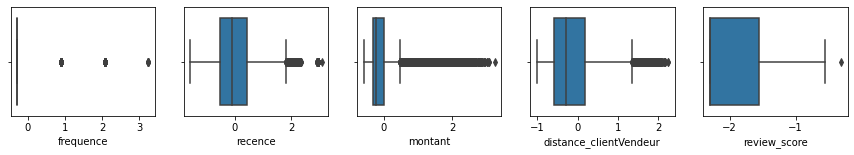

In [59]:
#boxplots
fig = plt.figure(1, figsize=(15, 2))

# Boxplot de la variable Frequence
plt.subplot(151)
sns.boxplot(df_cluster3["frequence"], orient="vertical")

# Boxplot de la variable recence
plt.subplot(152)
sns.boxplot(df_cluster3["recence"], orient="vertical")

# Boxplot de la variable Monetary
plt.subplot(153)
sns.boxplot(df_cluster3["montant"], orient="vertical")

# Boxplot de la variable distance_clientVendeur
plt.subplot(154)
sns.boxplot(df_cluster3["distance_clientVendeur"], orient="vertical")

# Boxplot de la variable review_score
plt.subplot(155)
sns.boxplot(df_cluster3["review_score"], orient="vertical")

plt.show()

/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/se

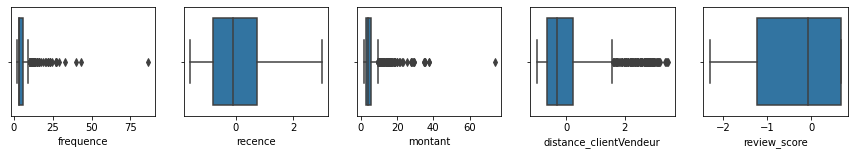

In [60]:
#boxplots
fig = plt.figure(1, figsize=(15, 2))

# Boxplot de la variable Frequence
plt.subplot(151)
sns.boxplot(df_cluster1["frequence"], orient="vertical")

# Boxplot de la variable recence
plt.subplot(152)
sns.boxplot(df_cluster1["recence"], orient="vertical")

# Boxplot de la variable Monetary
plt.subplot(153)
sns.boxplot(df_cluster1["montant"], orient="vertical")

# Boxplot de la variable distance_clientVendeur
plt.subplot(154)
sns.boxplot(df_cluster1["distance_clientVendeur"], orient="vertical")

# Boxplot de la variable review_score
plt.subplot(155)
sns.boxplot(df_cluster1["review_score"], orient="vertical")

plt.show()

--> Les clients qui préfèrent acheter en local et qui sont satisfaits

**Cluster 3**

/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/se

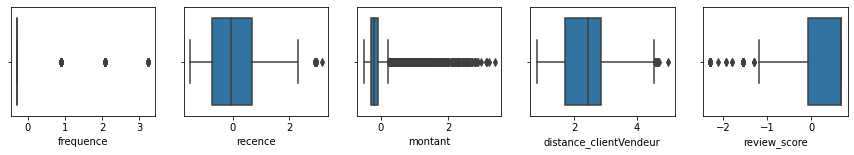

In [61]:
#boxplots
fig = plt.figure(1, figsize=(15, 2))

# Boxplot de la variable Frequence
plt.subplot(151)
sns.boxplot(df_cluster2["frequence"], orient="vertical")

# Boxplot de la variable recence
plt.subplot(152)
sns.boxplot(df_cluster2["recence"], orient="vertical")

# Boxplot de la variable Monetary
plt.subplot(153)
sns.boxplot(df_cluster2["montant"], orient="vertical")

# Boxplot de la variable distance_clientVendeur
plt.subplot(154)
sns.boxplot(df_cluster2["distance_clientVendeur"], orient="vertical")

# Boxplot de la variable review_score
plt.subplot(155)
sns.boxplot(df_cluster2["review_score"], orient="vertical")

plt.show()

--> ce cluster présente surtout les clients dont leur achats sont très fréquents et dont les sommes qui ont payé sont assez élevés aussi. 

**Cluster 4**

/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/se

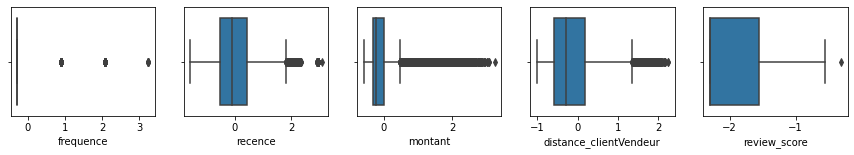

In [62]:
#boxplots
fig = plt.figure(1, figsize=(15, 2))

# Boxplot de la variable Frequence
plt.subplot(151)
sns.boxplot(df_cluster3["frequence"], orient="vertical")

# Boxplot de la variable recence
plt.subplot(152)
sns.boxplot(df_cluster3["recence"], orient="vertical")

# Boxplot de la variable Monetary
plt.subplot(153)
sns.boxplot(df_cluster3["montant"], orient="vertical")

# Boxplot de la variable distance_clientVendeur
plt.subplot(154)
sns.boxplot(df_cluster3["distance_clientVendeur"], orient="vertical")

# Boxplot de la variable review_score
plt.subplot(155)
sns.boxplot(df_cluster3["review_score"], orient="vertical")

plt.show()

--> Ce cluster présente surtout les clients qui ont passé des commandes récemment.

**Cluster 4**

/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_core.py:1319: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/soumaya/anaconda3/envs/openclassrooms/lib/python3.8/site-packages/se

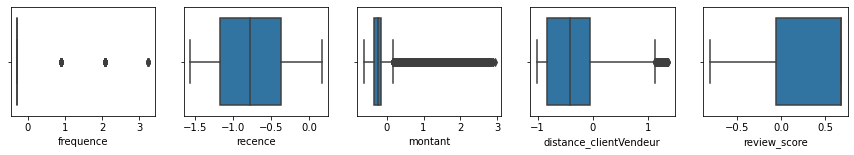

In [63]:
#boxplots
fig = plt.figure(1, figsize=(15, 2))

# Boxplot de la variable Frequence
plt.subplot(151)
sns.boxplot(df_cluster4["frequence"], orient="vertical")

# Boxplot de la variable recence
plt.subplot(152)
sns.boxplot(df_cluster4["recence"], orient="vertical")

# Boxplot de la variable Monetary
plt.subplot(153)
sns.boxplot(df_cluster4["montant"], orient="vertical")

# Boxplot de la variable distance_clientVendeur
plt.subplot(154)
sns.boxplot(df_cluster4["distance_clientVendeur"], orient="vertical")

# Boxplot de la variable review_score
plt.subplot(155)
sns.boxplot(df_cluster4["review_score"], orient="vertical")

plt.show()

--> Les clients qui sont assez distants de leurs vendeurs.

# Segmentation non supervisée par DBSCAN  

Il s'agit d'un algorithme fondé sur la densité dans la mesure qui s’appuie sur la densité estimée des clusters pour effectuer le partitionnement.   
Les hyperparamètres:  
  - la distance ϵ  et le nombre minimum de points MinPts devant se trouver dans un rayon ϵ pour que ces points soient considérés comme un cluster. Les paramètres d'entrées sont donc une estimation de la densité de points des clusters. L'idée de base de l'algorithme est ensuite, pour un point donné, de récupérer son ϵ voisinage et de vérifier qu'il contient bien MinPts points ou plus. Ce point est alors considéré comme faisant partie d'un cluster. On parcourt ensuite l' ϵ voisinage de proche en proche afin de trouver l'ensemble des points du cluster. 

In [ ]:
from sklearn.cluster import DBSCAN
# Compute DBSCAN
db = DBSCAN(eps=3, min_samples=5).fit(final_features)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(final_features, labels))
